In [55]:
## Import packages (yeah idk )
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy import stats
from sklearn import metrics
from sklearn.linear_model import LinearRegression # need
from sklearn.model_selection import train_test_split # need
from sklearn.preprocessing import StandardScaler # need
from pathlib import Path


### Random Forest Regression 



In [56]:
df = pd.read_csv("CZHC\data\pdf.csv")
df =  df.fillna(0)
df.head()
df = df.drop([ 'actor_id'], axis=1)

In [57]:
#seperating our target and predictor 
X_rfr = df.drop([ 'Participation grade: Formative (not included in final grade)', 'Assignment 1 Current Score', 'Assignment 2 Current Score', 
'Assignment 3 Current Score', 'Participation & engagement Current Score', 'Assignment Average', 'Total Average'], axis=1)
y_rfr = df['Assignment Average']



In [58]:

from sklearn.ensemble import  RandomForestRegressor

def randomForest(fileName):

  # make train test splits
  X_rfr_train, X_rfr_test, y_rfr_train, y_rfr_test = train_test_split(X_rfr, y_rfr, test_size= 0.4, random_state = 42)

  # making things scaler
  scaler = StandardScaler()
  scaler.fit(X_rfr_train)

  X_rfr_train_sc = scaler.transform(X_rfr_train)
  X_rfr_test_sc = scaler.transform(X_rfr_test)

  # create an object of the RandomForestRegressor
  model_RFR = RandomForestRegressor(n_estimators = 30)

  # fit the model with the training data
  model_RFR.fit(X_rfr_train_sc, y_rfr_train)

  # predict the target on train and test data
  predict_train = model_RFR.predict(X_rfr_train_sc)
  predict_test = model_RFR.predict(X_rfr_test_sc)

  # Root Mean Squared Error on train and test data
  print('RMSE on train data: ', metrics.mean_squared_error(y_rfr_train, predict_train)**(0.5))
  print('RMSE on test data: ',  metrics.mean_squared_error(y_rfr_test, predict_test)**(0.5))

  r2 = metrics.r2_score(y_rfr_test, predict_test)
  print(r2)

  # plot to show feature importances
  plt.figure(figsize=(10,7))
  feat_importances = pd.Series(model_RFR.feature_importances_, index = X_rfr_train.columns)
  feat_importances.nlargest(7).plot(kind='barh')
  plt.savefig(f"random_forest_${fileName}.pdf")

### Linear Regression 

What if the relationship is linear ?

In [59]:
from sklearn.linear_model import LinearRegression 

def linearR(fileName):
  X = df.drop(['Participation grade: Formative (not included in final grade)','Assignment 1 Current Score',
  'Assignment 2 Current Score','Assignment 3 Current Score','Participation & engagement Current Score','Assignment Average',
  'Total Average'], axis = 1).to_numpy()
  y = df['Assignment Average'].to_numpy()

  # seperating test train set 
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 42)

  scaler = StandardScaler()
  scaler.fit(X_train)

  X_train_sc = scaler.transform(X_train)
  X_test_sc = scaler.transform(X_test)

  lm = LinearRegression()
  lm.fit(X_train_sc, y_train)
  y_pred = lm.predict(X_test_sc)


  print('RMSE on test data: ',  metrics.mean_squared_error(y_test, y_pred)**(0.5))
  print('R^2:', metrics.r2_score(y_test, y_pred))
  # plt.savefig(f"random_forest_${fileName}.pdf")

### Neural Networks

for funzies !!

In [60]:
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA

#define RMSE as a function, since we'll use this in the NN model 
def rmse(target,prediction):
    return(np.sqrt(((target - prediction)**2).sum()/len(target)))

df_norm = (df - df.mean())/df.std()
df_norm.tail()
def pcaMLPRegressor(fileName):


    #unpack variables
    target = df_norm['Assignment Average']


    #target variable: y; predictor variable(s): x
    y = target
    y-=np.min(target)
    y/=np.max(target) #now y ranges from 0 to 1
    x = df_norm.drop(['Participation grade: Formative (not included in final grade)','Assignment 1 Current Score',
    'Assignment 2 Current Score','Assignment 3 Current Score','Participation & engagement Current Score','Assignment Average',
    'Total Average'], axis = 1)

    #first do PCA, then use PCs as predictors
    n_modes = np.min(np.shape(x))
    pca = PCA(n_components = n_modes)
    PCs = pca.fit_transform(x)
    eigvecs = pca.components_
    fracVar = pca.explained_variance_ratio_

    #plot fraction of variance explained by each mode

    plt.figure(figsize=(5,5))

    plt.subplot(1,1,1)
    plt.scatter(range(len(fracVar)),fracVar)
    plt.xlabel('Mode Number')
    plt.ylabel('Fraction Variance Explained')
    plt.title('Variance Explained by All Modes')

    plt.tight_layout()

    plt.show()

    #take first 5 PCs in MLP NN model
    #training: first 100 points
    #testing: remaining points

    ntrain = 17

    x_train = PCs[:ntrain,:5] #train on 100 observations of first 5 PCs
    y_train = y[:ntrain]

    x_test = PCs[ntrain:,:5] #test on remaining observations
    y_test = y[ntrain:]

    # Get the indices that would sort the absolute loadings in descending order
    component_number = 0  # Replace with the desired component number (0-based index)
    sorted_indices = np.argsort(np.abs(eigvecs[component_number]))[::-1]

    # Extract the variable names in order of influence
    variable_names = x.columns
    influential_variables = variable_names[sorted_indices]

    influential_variables

    ## OH GOD

    #This chunk of code is relatively flexible and can be used to loop through a range of parameters
    #We'll use this code several different times in the notebook
    #Play around and see what kinds of models you can make

    #First: MLP using 1 hidden layer with 10 neurons
    #Second: MLP using 1 hidden layer with 1-10 neurons
    #Third: something else!

    ##### Play around with these parameters
    num_models = 10 #number of models to build for the ensemble
    min_nhn = 1 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')
    max_nhn = 8 #maximum number of hidden neurons to loop through
    max_hidden_layers = 2 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')
    batch_size = 32
    solver = 'adam' #use stochastic gradient descent as an optimization method (weight updating algorithm)
    activation = 'relu'
    learning_rate_init = 0.01
    #####

    max_iter = 1500 #max number of epochs to run
    early_stopping = True #True = stop early if validation error begins to rise
    validation_fraction = 0.1 #fraction of training data to use as validation

    y_out_all_nhn = []
    y_out_ensemble = []
    RMSE_ensemble = [] #RMSE for each model in the ensemble
    RMSE_ensemble_cumsum = [] #RMSE of the cumulative saltation for each model
    nhn_best = []
    nhl_best = []

    for model_num in range(num_models): #for each model in the ensemble
        
        print('Model Number: ' + str(model_num))
        
        RMSE = []
        y_out_all_nhn = []
        nhn = []
        nhl = []
        
        for num_hidden_layers in range(1,max_hidden_layers+1):
        
            print('\t # Hidden Layers = ' + str(num_hidden_layers))
        
            for num_hidden_neurons in range(min_nhn,max_nhn+1): #for each number of hidden neurons

                print('\t\t # hidden neurons = ' + str(num_hidden_neurons))
                
                hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
                model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                                    verbose=False,
                                    max_iter=max_iter, 
                                    early_stopping = early_stopping,
                                    validation_fraction = validation_fraction,
                                    batch_size = batch_size,
                                    solver = solver,
                                    activation = activation,
                                    learning_rate_init = learning_rate_init)

                model.fit(x_train,y_train) #train the model

                y_out_this_nhn = model.predict(x_test) #model prediction for this number of hidden neurons (nhn)
                y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE

                RMSE.append(rmse(y_test,y_out_this_nhn)) #RMSE between cumulative curves
                
                nhn.append(num_hidden_neurons)
                nhl.append(num_hidden_layers)
            
        indBest = RMSE.index(np.min(RMSE)) #index of model with lowest RMSE
        RMSE_ensemble.append(np.min(RMSE))
        nhn_best.append(nhn[indBest])
        nhl_best.append(nhl[indBest])
        #nhn_best.append(indBest+1) #the number of hidden neurons that achieved best model performance of this model iteration
        y_out_ensemble.append(y_out_all_nhn[indBest])
        
        print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')
        
    y_out_ensemble_mean = np.mean(y_out_ensemble,axis=0)
    RMSE_ensemble_mean = rmse(y_out_ensemble_mean,y_test)
    #visualize

    plt.figure(figsize=(12,8))

    plt.subplot(241)
    plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*')
    plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
    plt.xlabel('Model #')
    plt.ylabel('RMSE')
    plt.title('Error')


    plt.subplot(242)
    plt.scatter(range(len(nhn_best)),nhn_best)
    plt.xlabel('Model #')
    plt.ylabel('# Hidden Neurons')
    plt.title('Hidden Neurons')

    plt.subplot(243)
    plt.scatter(range(len(nhl_best)),nhl_best)
    plt.xlabel('Model #')
    plt.ylabel('# Hidden Layers')
    plt.title('Hidden Layers')

    plt.subplot(244)
    plt.scatter(y_test,y_out_ensemble_mean)
    #plt.plot((np.min(y_test),np.max(y_test)),'k--')
    plt.xlabel('y_test')
    plt.ylabel('y_model')
    plt.title('Ensemble')

    plt.subplot(212)
    plt.plot(y_out_ensemble_mean)
    plt.plot(np.array(y_test),alpha = 0.5)

    plt.tight_layout()
    plt.savefig(f"pca_mlp_explore_${fileName}.pdf")

    #visualize individual model runs


    plt.figure(figsize = (12,5))

    plt.scatter(range(len(y_test)),y_test,label='Observations',zorder = 0,alpha = 0.3)
    plt.plot(range(len(y_test)),np.transpose(y_out_ensemble[0]),
            color = 'k',alpha = 0.4,label='Individual Models',zorder=1) #plot first ensemble member with a label
    plt.plot(range(len(y_test)),np.transpose(y_out_ensemble[1:]),
            color = 'k',alpha = 0.4,zorder=1) #plot remaining ensemble members without labels for a nicer legend
    plt.plot(range(len(y_test)),y_out_ensemble_mean,color = 'k',label = 'Ensemble',zorder=2, linewidth = 3)
    plt.xlabel('File Clicks', fontsize = 20)
    plt.ylabel('y', fontsize = 20)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.title('MLP Model Results', fontsize = 24)
    plt.legend(fontsize = 16, loc = 'best')

    plt.tight_layout()

    plt.savefig(f"mlp_model_results_${fileName}.pdf")

    plt.show()

    #visualize performance metrics/etc


    plt.figure(figsize=(16,4))

    plt.subplot(131)
    plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*', s = 150)
    plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble, s = 150)
    plt.xlabel('Model #', fontsize = 20)
    plt.ylabel('RMSE', fontsize = 20)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    #plt.ylim((np.min(RMSE_ensemble) - 0.005, np.max(RMSE_ensemble)+0.005))
    plt.title('Error', fontsize = 20)

    plt.subplot(132)
    plt.scatter(range(len(nhn_best)),nhn_best, s = 150)
    plt.xlabel('Model #', fontsize = 20)
    plt.ylabel('# Hidden Neurons', fontsize = 20)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.title('Hidden Neurons', fontsize = 20)

    plt.subplot(133)
    plt.scatter(range(len(nhl_best)),nhl_best)
    plt.xlabel('Model #', fontsize = 20)
    plt.ylabel('# Hidden Layers', fontsize = 20)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.title('Hidden Layers', fontsize = 20)

    plt.tight_layout()
    plt.savefig(f"mlp_perf_${fileName}.pdf")

    plt.show()

    print(RMSE_ensemble_mean)


In [61]:
df = pd.read_csv("CZHC\data\mod0.csv")
df =  df.fillna(0)
df.head()

,actor_id,Participation grade: Formative (not included in final grade),Assignment 1 Current Score,Assignment 2 Current Score,Assignment 3 Current Score,Participation & engagement Current Score,Assignment Average,Total Average,0.6 Course readings & resources,0.7 [Wikipage] Useful sources on institutional planning,...,0.5 Course schedule,0.13 Learning analytics,0.3 Evolving thinking about planning for eLearning,0.1 Course overview,0.11 Academic misconduct,0.4 How to succeed in THE COURSE,"0.12 Accessibility, equity & diversity, netiquette, & university policies",0.8 Assignments & assessment,0.2 THE COURSE author and pioneer,0.14 Getting Canvas help
0,LEARNER_1,9.0,79,84,73,90,78.666667,81.50,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,LEARNER_10,8.5,88,72,74,85,78.000000,79.75,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,LEARNER_11,9.0,90,79,82,90,83.666667,85.25,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,LEARNER_12,8.0,86,87,73,80,82.000000,81.50,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,LEARNER_13,8.0,88,86,87,80,87.000000,85.25,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


RMSE on train data:  1.8315585951831637
RMSE on test data:  6.501019456074094
-0.07778262880934395
RMSE on test data:  161.46819454602968
R^2: -665.613070027247


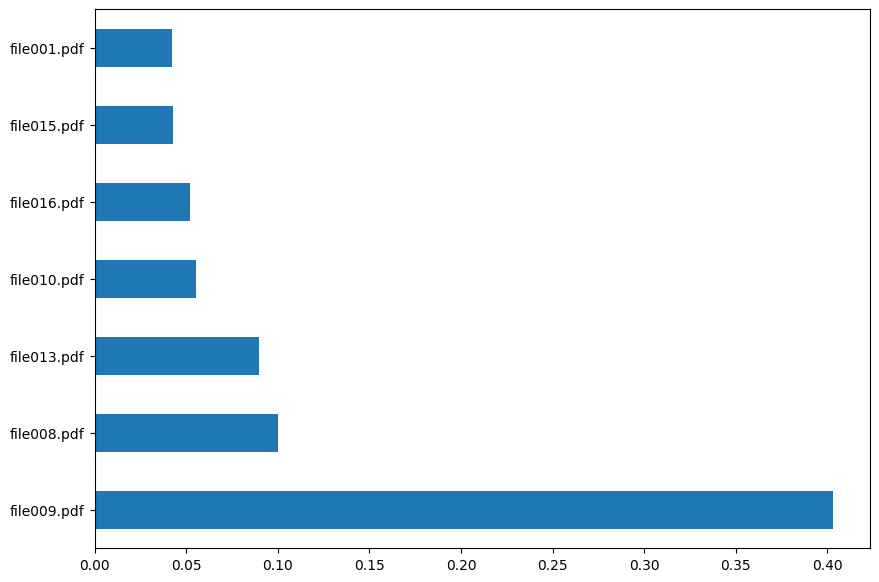

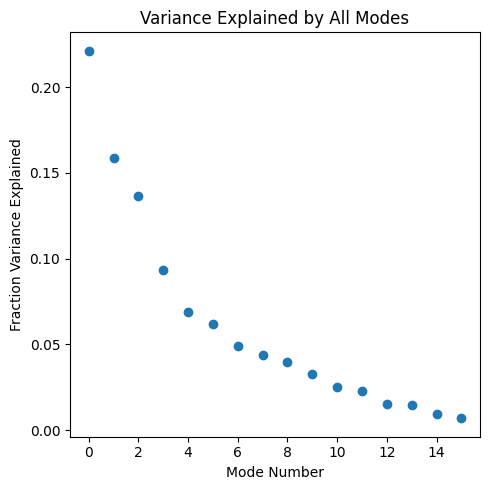

Model Number: 0
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 4 hidden neurons
Model Number: 1
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 8
	 BEST: 2 hidden layers, 3 hidden neurons
Model Number: 2
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


	 BEST: 2 hidden layers, 5 hidden neurons
Model Number: 3
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-202

		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 2 hidden layers, 5 hidden neurons
Model Number: 4
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 2 hidden layers, 7 hidden neurons
Model Number: 5
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 2 hidden neurons
Model Number: 6
	 # Hidden Layers = 1
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


	 BEST: 1 hidden layers, 1 hidden neurons
Model Number: 7
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 5 hidden neurons
Model Number: 8
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

	 BEST: 2 hidden layers, 8 hidden neurons
Model Number: 9
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 3 hidden neurons


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

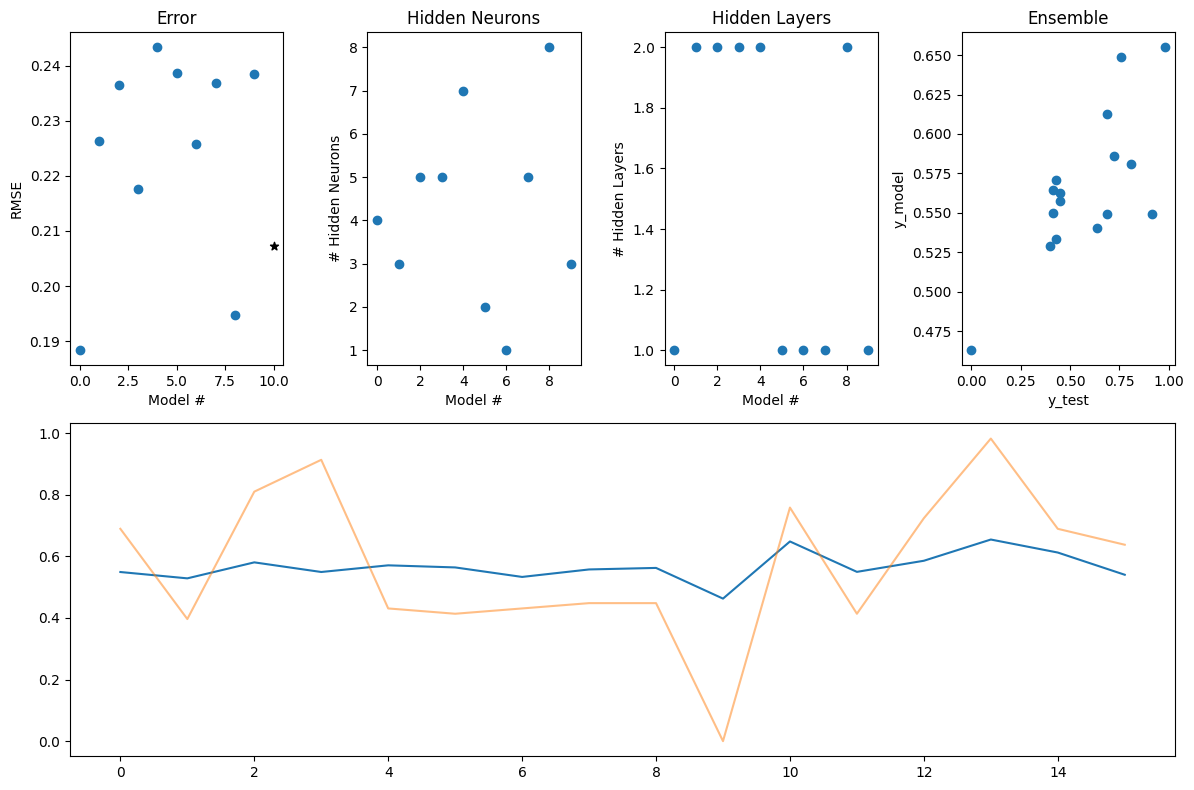

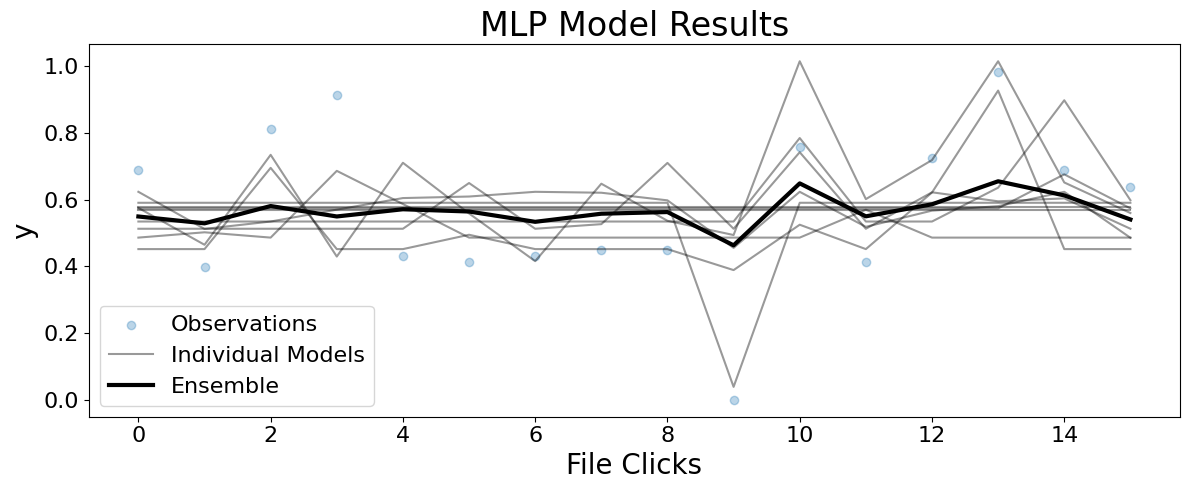

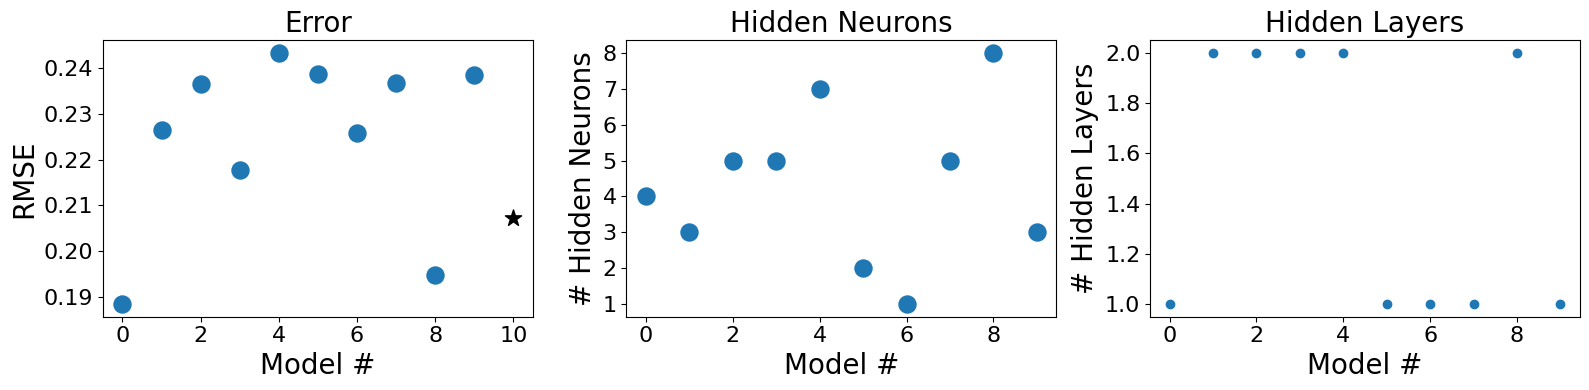

0.20728237400146077
RMSE on train data:  1.5132509788585102
RMSE on test data:  6.407242787743682
-0.046913041243405784
RMSE on test data:  7.512829862779484
R^2: -0.44313497989671013


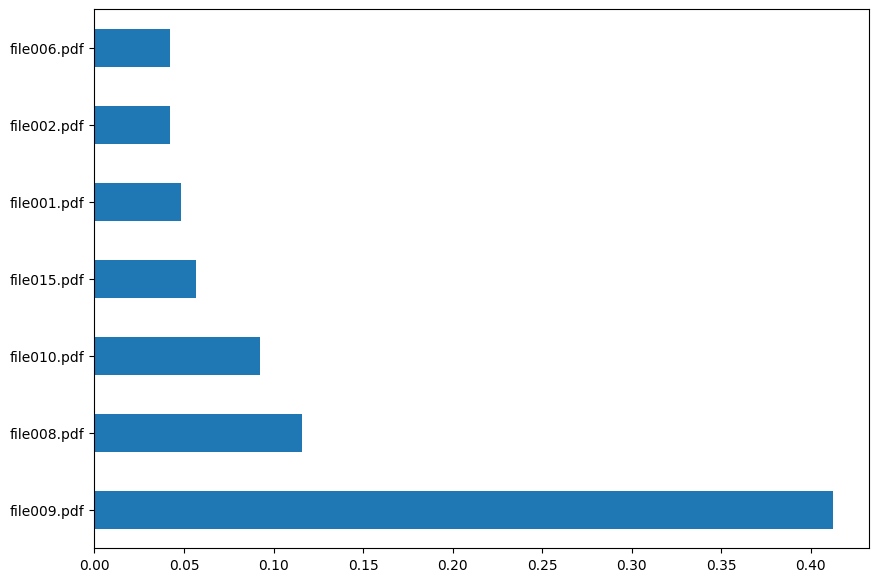

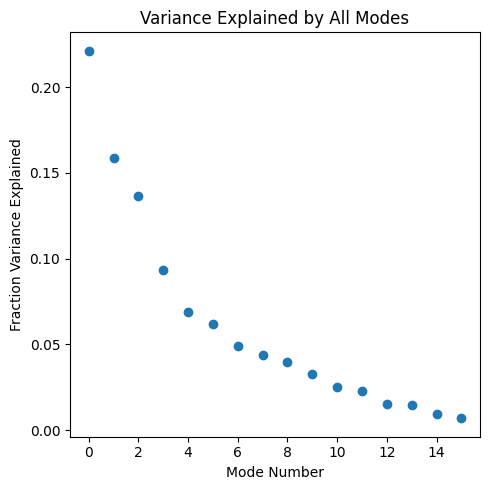

Model Number: 0
	 # Hidden Layers = 1
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 2 hidden layers, 1 hidden neurons
Model Number: 1
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 2 hidden layers, 3 hidden neurons
Model Number: 2
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 4
		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

	 BEST: 1 hidden layers, 1 hidden neurons
Model Number: 3
	 # Hidden Layers = 1
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-202

		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 2 hidden neurons
Model Number: 4
	 # Hidden Layers = 1
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 4 hidden neurons
Model Number: 5
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 8
	 BEST: 2 hidden layers, 4 hidden neurons
Model Number: 6
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 2 hidden layers, 4 hidden neurons
Model Number: 7
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 1 hidden neurons
Model Number: 8
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 2 hidden layers, 7 hidden neurons
Model Number: 9
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 1 hidden neurons


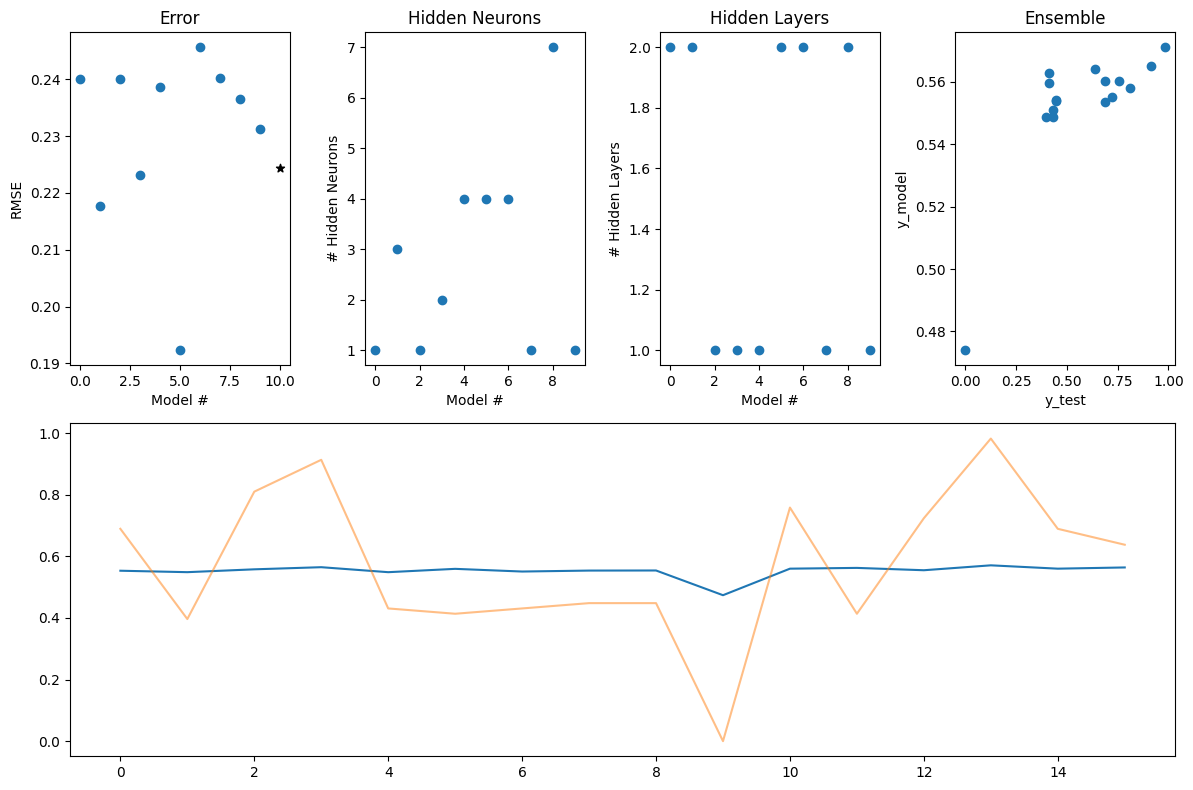

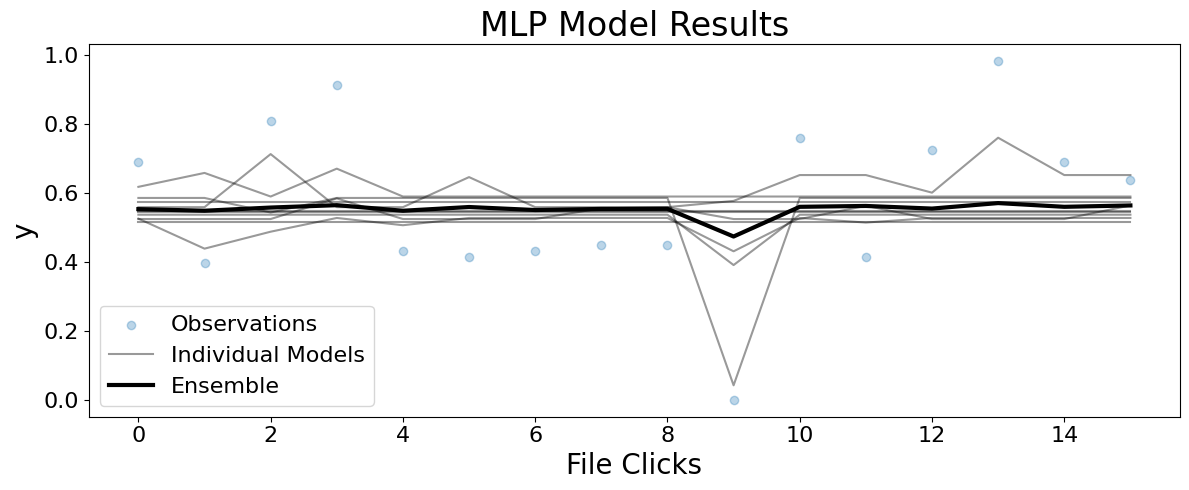

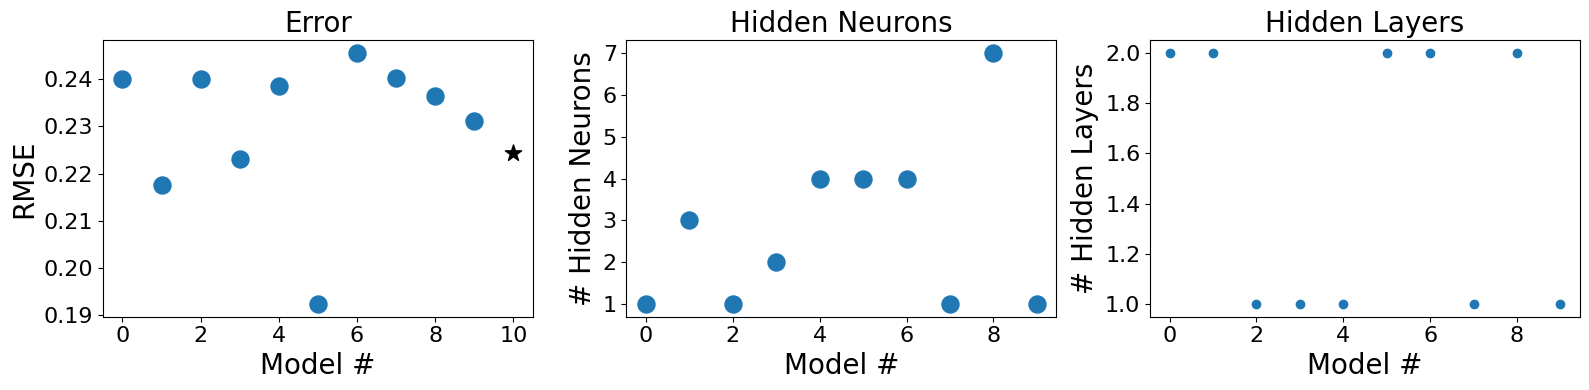

0.22436698770107058
RMSE on train data:  1.301146592871206
RMSE on test data:  6.208369642307086
0.017068210001478956
RMSE on test data:  6.256462799274944
R^2: -0.0008236955352336484


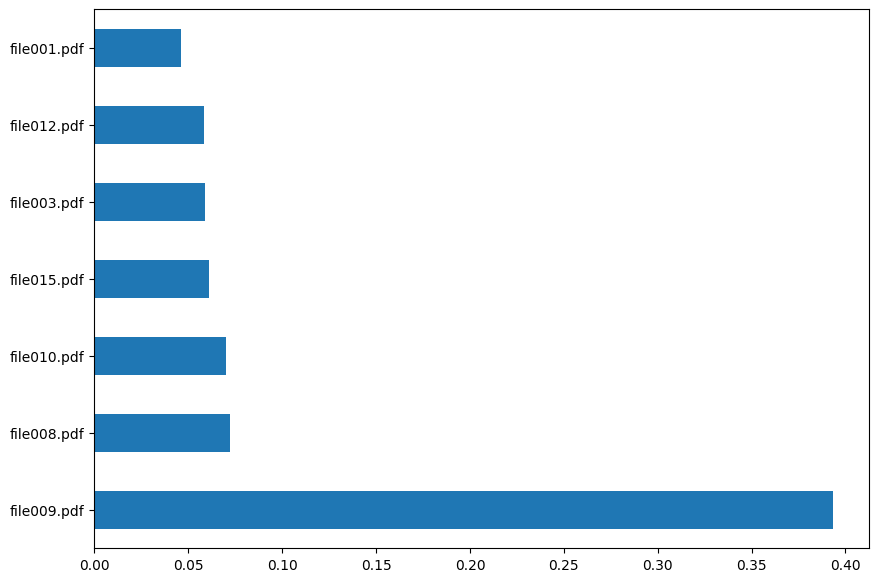

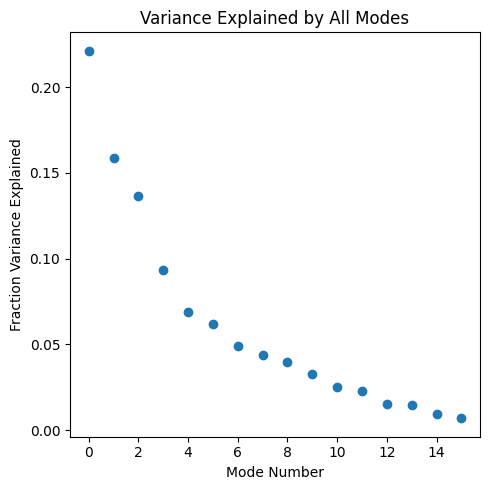

Model Number: 0
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 6 hidden neurons
Model Number: 1
	 # Hidden Layers = 1
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 8
	 BEST: 1 hidden layers, 1 hidden neurons
Model Number: 2
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8
	 BEST: 2 hidden layers, 1 hidden neurons
Model Number: 3
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4
		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

	 BEST: 1 hidden layers, 1 hidden neurons
Model Number: 4
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4
		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 6 hidden neurons
Model Number: 5
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 3 hidden neurons
Model Number: 6
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 8 hidden neurons
Model Number: 7
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8
	 BEST: 2 hidden layers, 8 hidden neurons
Model Number: 8
	 # Hidden Layers = 1
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

	 BEST: 2 hidden layers, 1 hidden neurons
Model Number: 9
	 # Hidden Layers = 1
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 1 hidden neurons


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


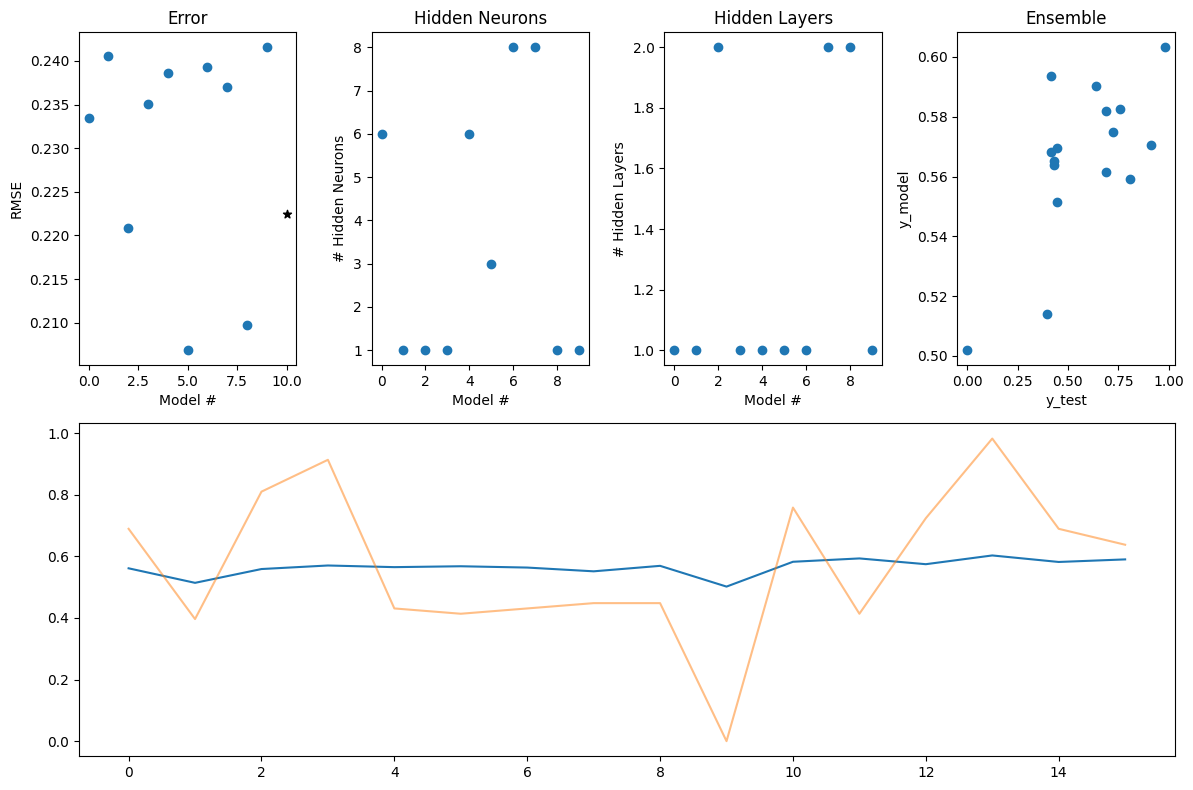

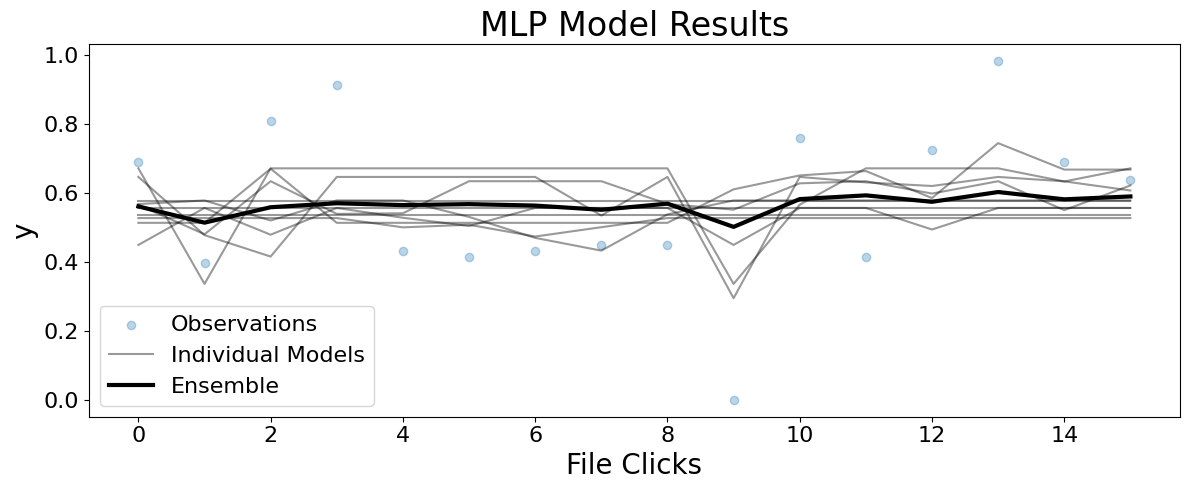

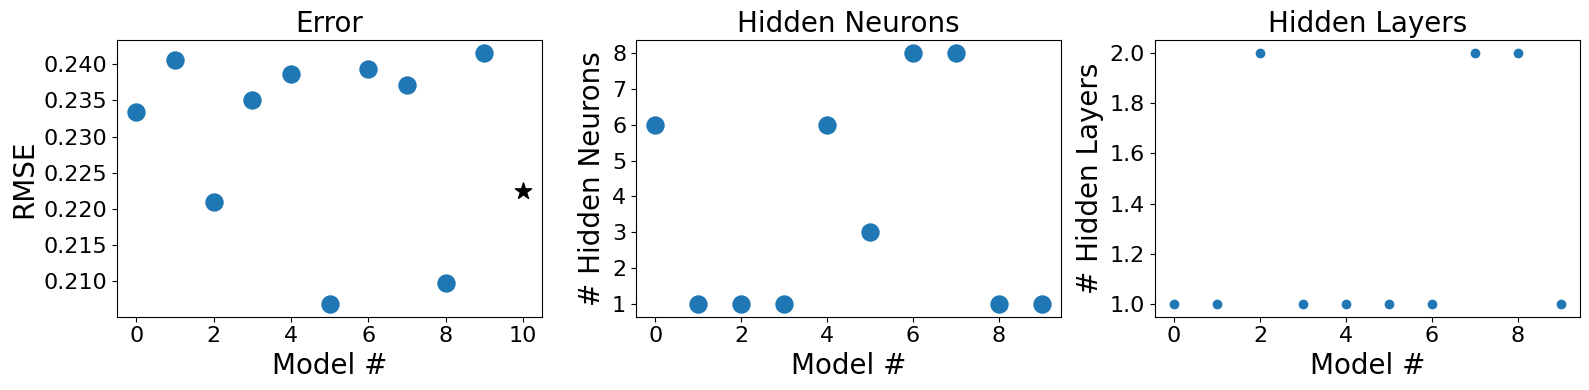

0.22242642729814224
RMSE on train data:  1.8582849275594993
RMSE on test data:  6.208873152199666
0.016908768480502157
RMSE on test data:  6.580228821375811
R^2: -0.10708722180393448


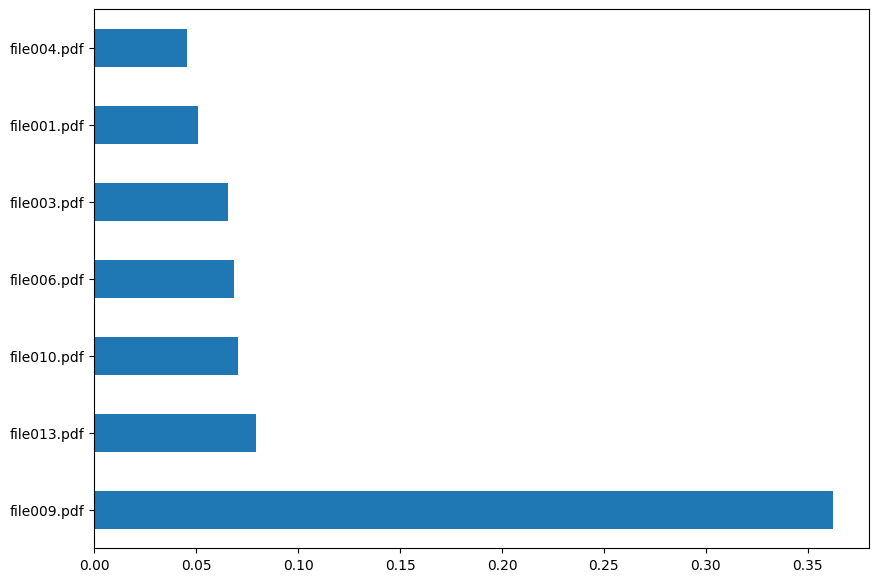

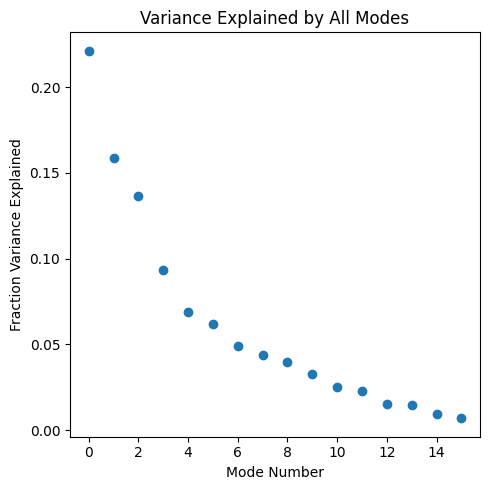

Model Number: 0
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4
		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 2 hidden layers, 1 hidden neurons
Model Number: 1
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8
	 BEST: 1 hidden layers, 2 hidden neurons
Model Number: 2
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 2 hidden layers, 1 hidden neurons
Model Number: 3
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 3 hidden neurons
Model Number: 4
	 # Hidden Layers = 1
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 8
	 BEST: 1 hidden layers, 8 hidden neurons
Model Number: 5
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8
	 BEST: 1 hidden layers, 4 hidden neurons
Model Number: 6
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 1 hidden neurons
Model Number: 7
	 # Hidden Layers = 1
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


	 # Hidden Layers = 2
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 7 hidden neurons
Model Number: 8
	 # Hidden Layers = 1
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8
	 BEST: 1 hidden layers, 5 hidden neurons
Model Number: 9
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8
	 BEST: 1 hidden layers, 6 hidden neurons


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


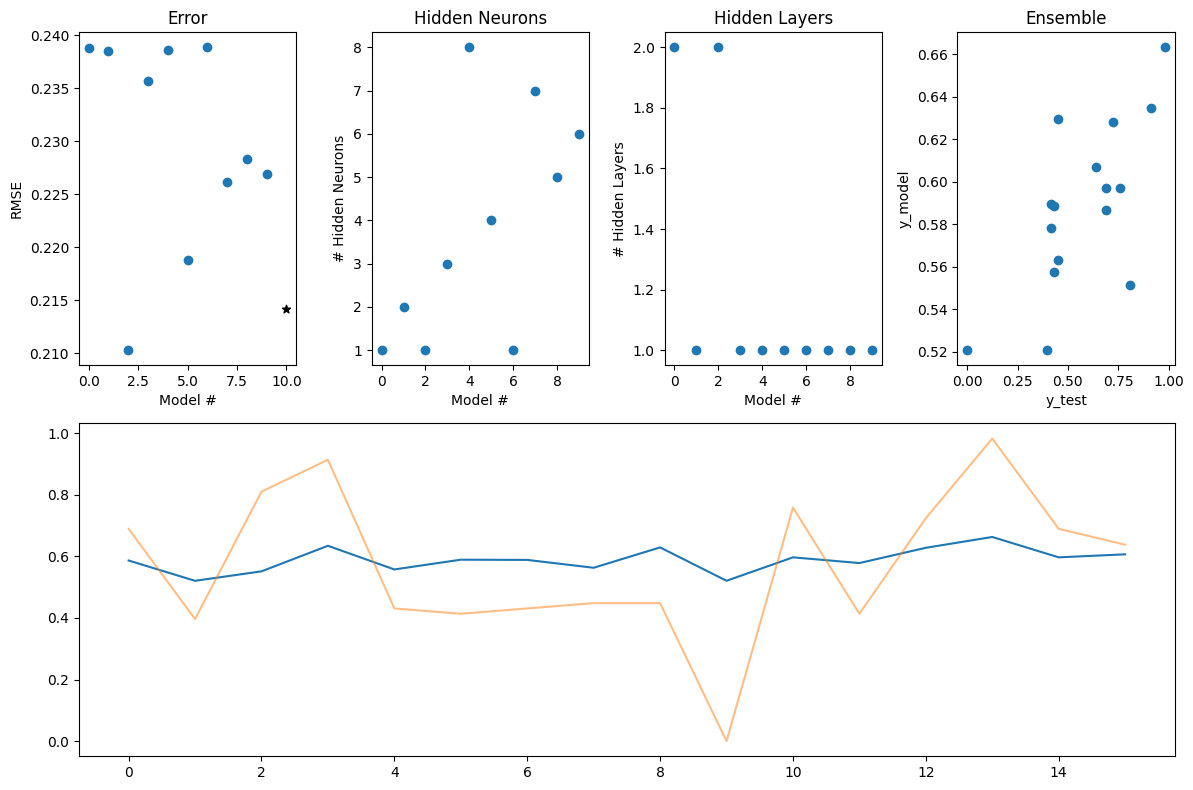

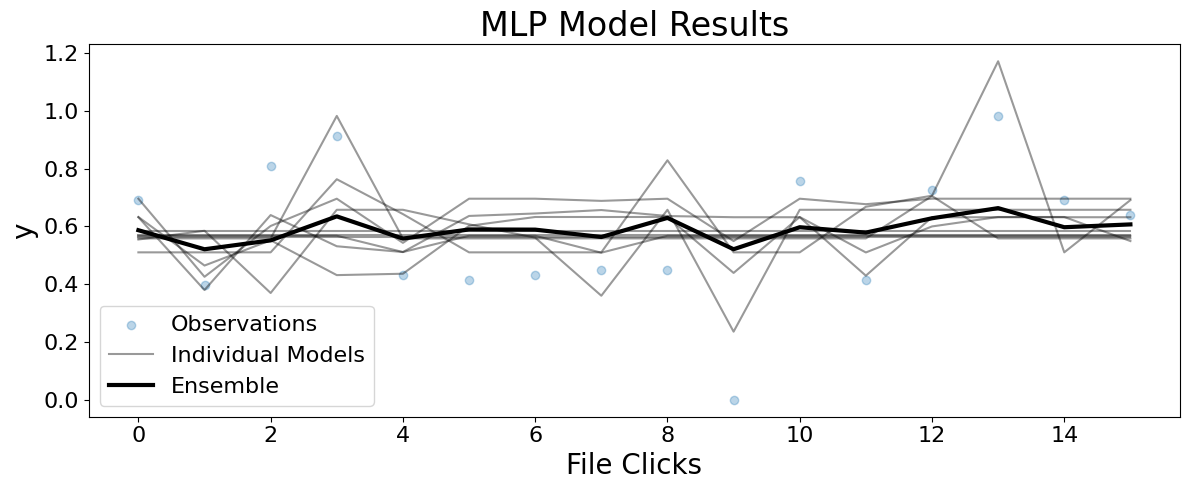

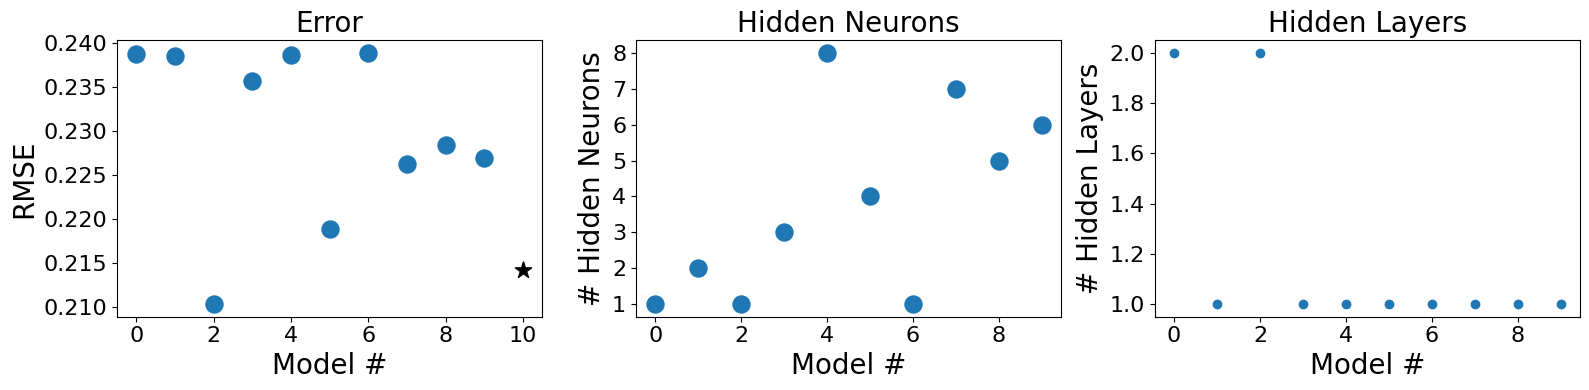

0.21420387404732216
RMSE on train data:  1.622248257421456
RMSE on test data:  6.1151883945246555
0.04635237764798972
RMSE on test data:  6.2785151975940625
R^2: -0.007891414141412811


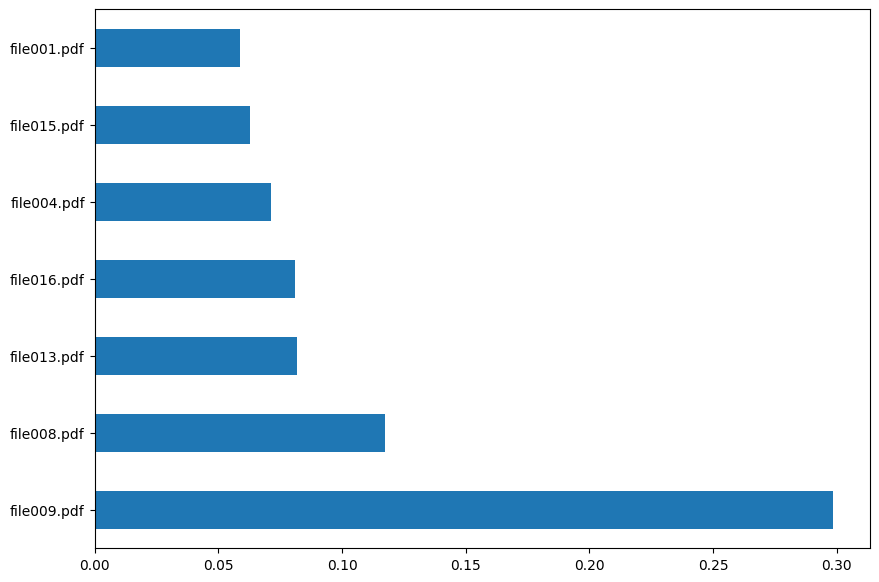

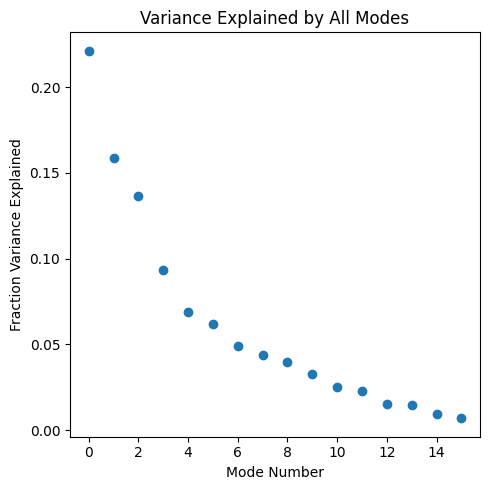

Model Number: 0
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 3 hidden neurons
Model Number: 1
	 # Hidden Layers = 1
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 8
	 BEST: 1 hidden layers, 8 hidden neurons
Model Number: 2
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

	 BEST: 1 hidden layers, 2 hidden neurons
Model Number: 3
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 3 hidden neurons
Model Number: 4
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-202

		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 8
	 BEST: 2 hidden layers, 7 hidden neurons
Model Number: 5
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 8
	 BEST: 2 hidden layers, 1 hidden neurons
Model Number: 6
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 8 hidden neurons
Model Number: 7
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


	 # Hidden Layers = 2
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-202

		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 2 hidden layers, 1 hidden neurons
Model Number: 8
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4
		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 3 hidden neurons
Model Number: 9
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 2 hidden layers, 7 hidden neurons


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


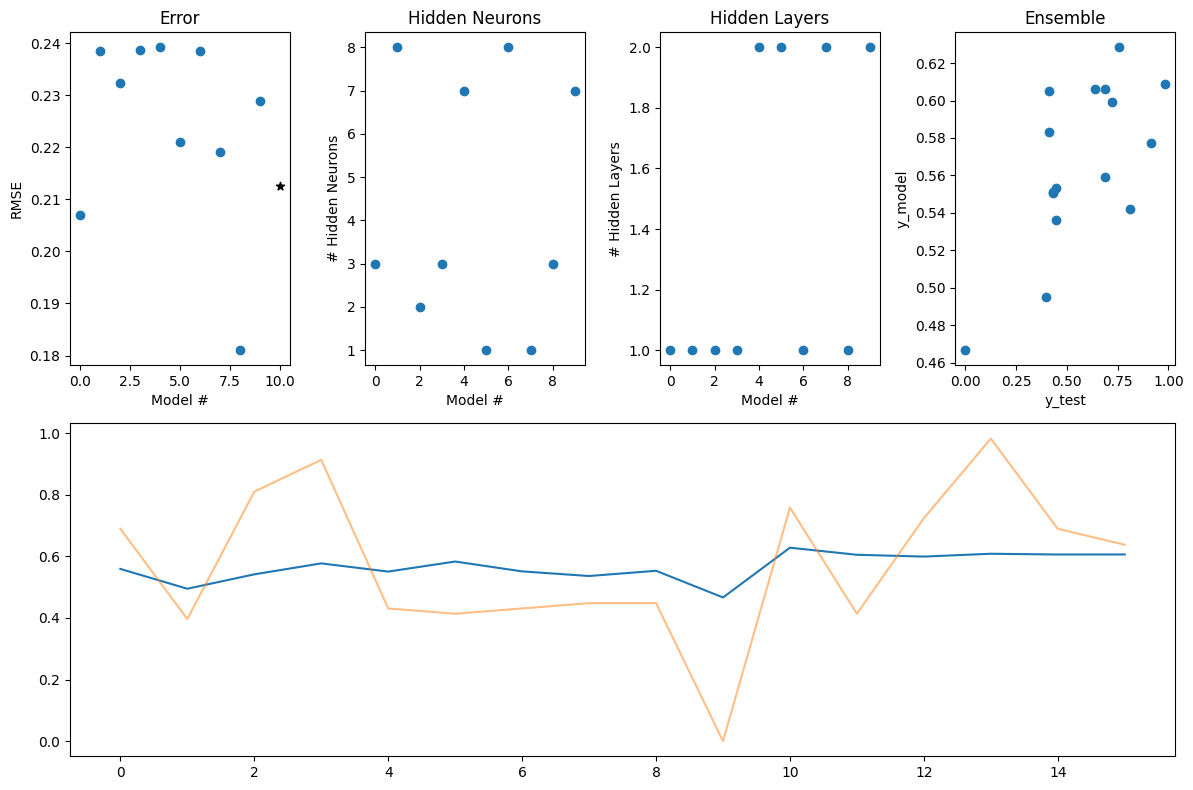

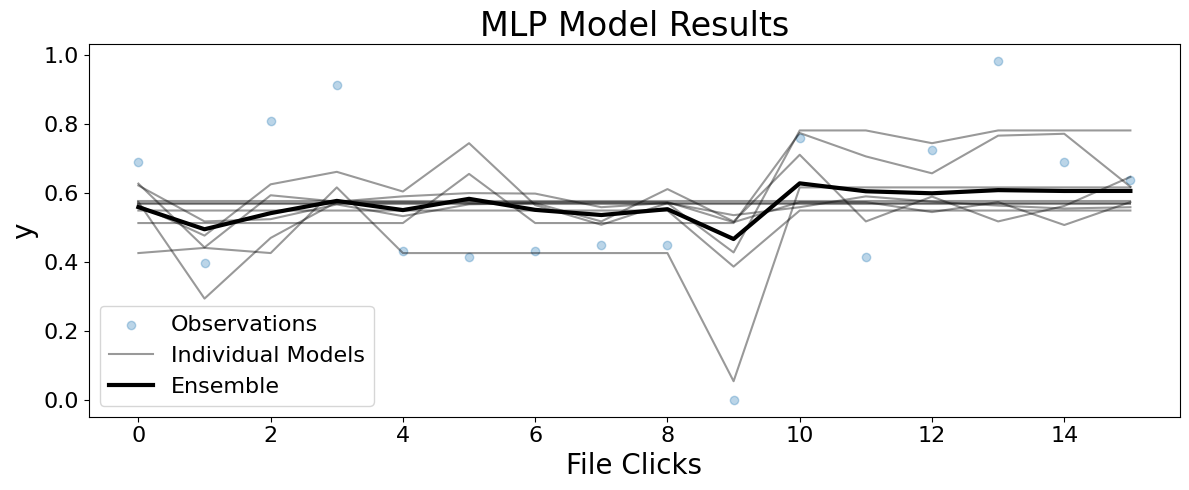

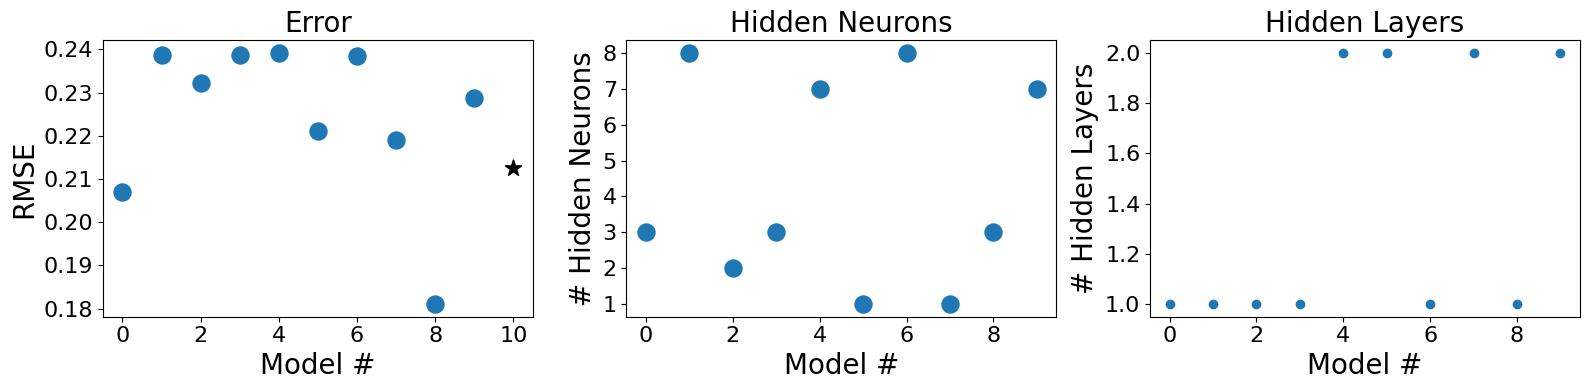

0.21260987881902335
RMSE on train data:  1.5450123067277604
RMSE on test data:  5.959013447697637
0.09444052506794565
RMSE on test data:  6.856171311162741
R^2: -0.20188569725028427


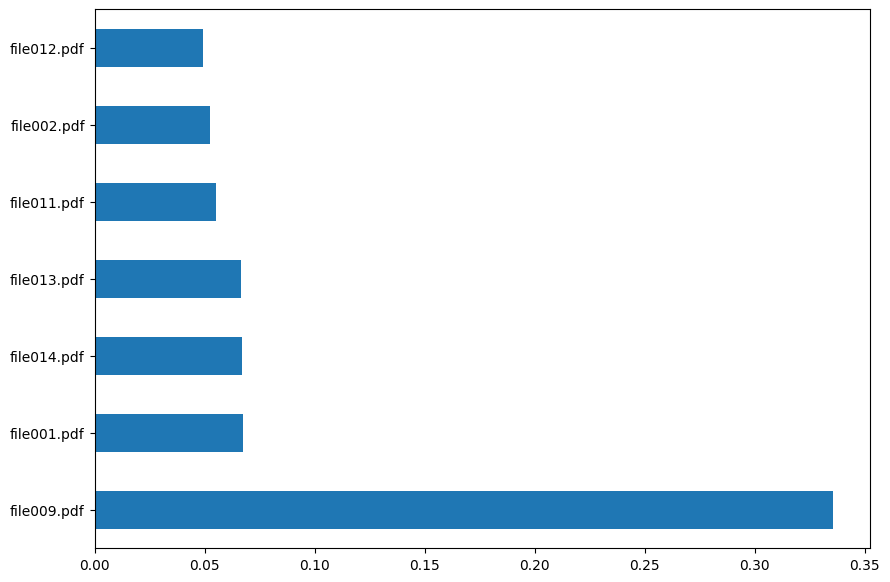

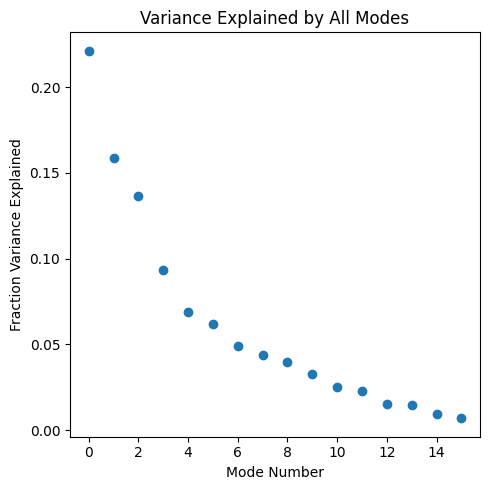

Model Number: 0
	 # Hidden Layers = 1
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 5 hidden neurons
Model Number: 1
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 2 hidden layers, 3 hidden neurons
Model Number: 2
	 # Hidden Layers = 1
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 2 hidden layers, 6 hidden neurons
Model Number: 3
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 8 hidden neurons
Model Number: 4
	 # Hidden Layers = 1
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


	 BEST: 2 hidden layers, 5 hidden neurons
Model Number: 5
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 2 hidden layers, 1 hidden neurons
Model Number: 6
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 2 hidden layers, 7 hidden neurons
Model Number: 7
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 8
	 BEST: 2 hidden layers, 3 hidden neurons
Model Number: 8
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 8
	 BEST: 1 hidden layers, 1 hidden neurons
Model Number: 9
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 2 hidden layers, 1 hidden neurons


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


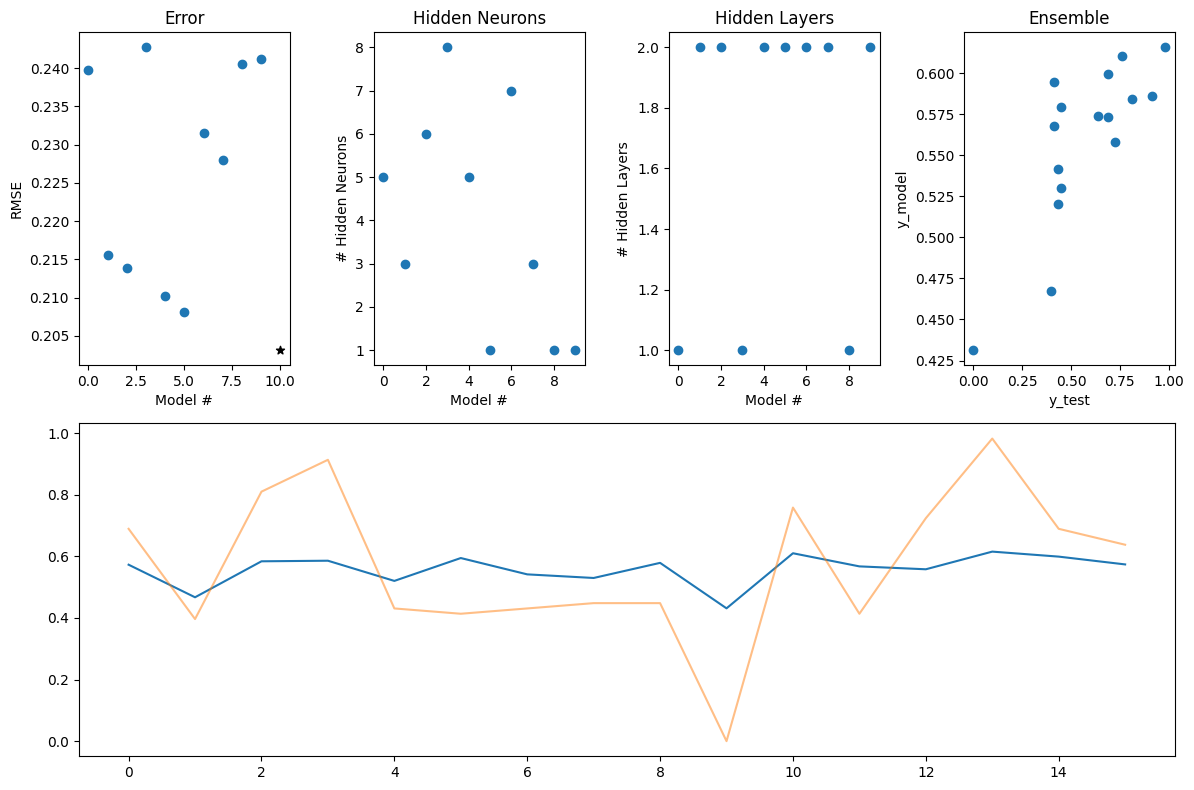

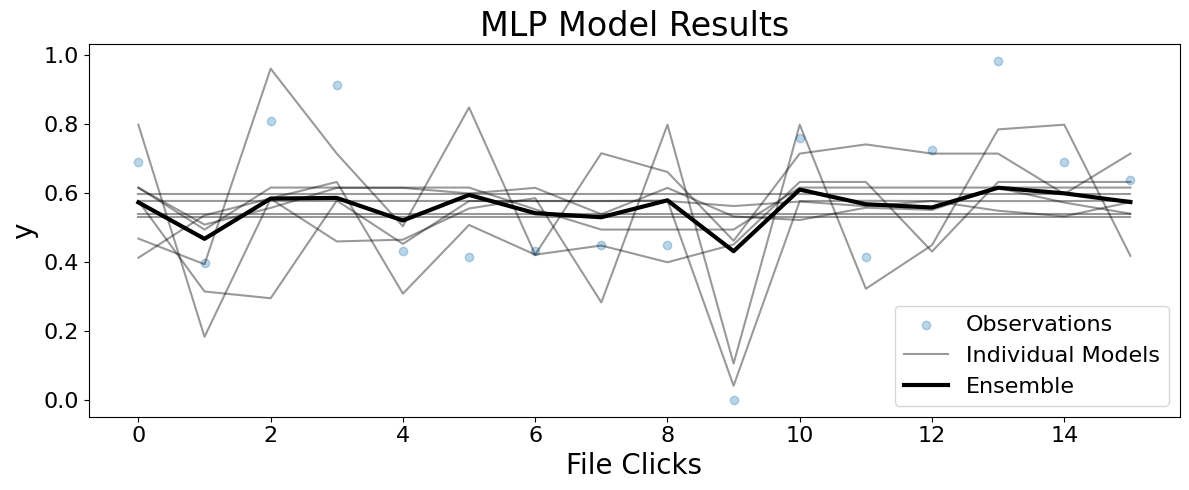

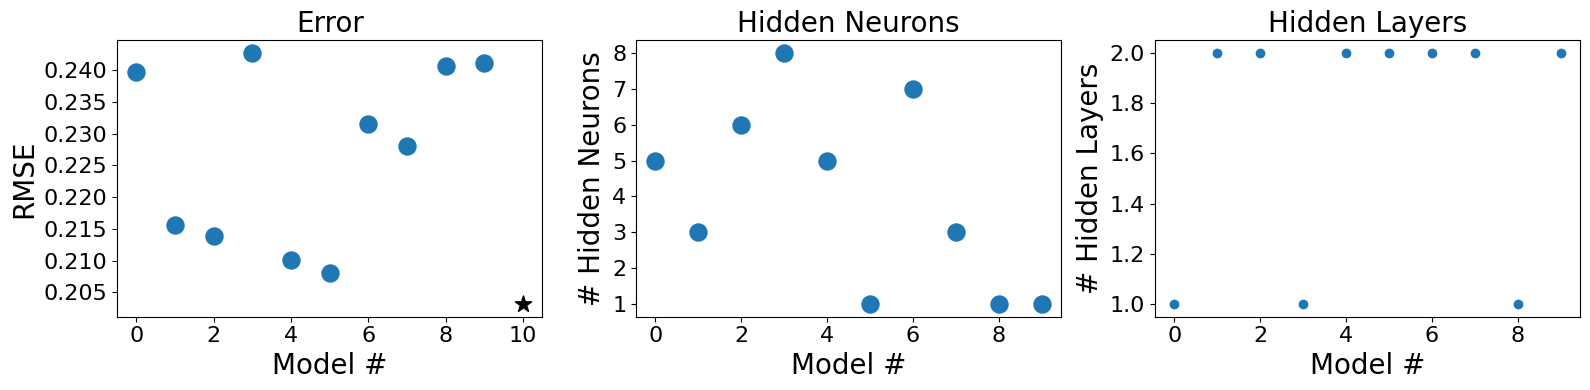

0.2031464112341615
RMSE on train data:  1.6264364870857115
RMSE on test data:  6.367211672287784
-0.03387211909764409
RMSE on test data:  6.334479135846043
R^2: -0.025939299154035034


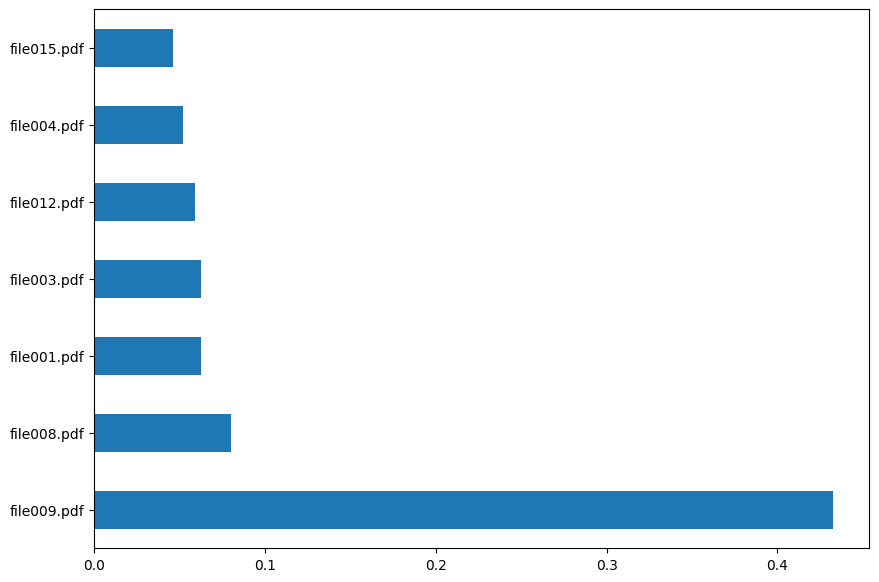

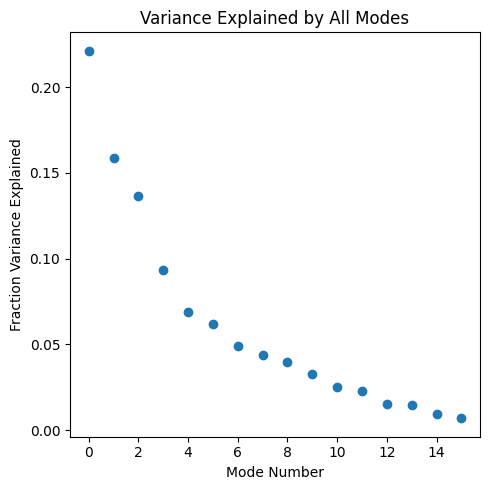

Model Number: 0
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 8
	 BEST: 2 hidden layers, 5 hidden neurons
Model Number: 1
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 7 hidden neurons
Model Number: 2
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 2 hidden layers, 3 hidden neurons
Model Number: 3
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

	 BEST: 2 hidden layers, 3 hidden neurons
Model Number: 4
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

	 BEST: 2 hidden layers, 4 hidden neurons
Model Number: 5
	 # Hidden Layers = 1
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 1 hidden neurons
Model Number: 6
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8
	 BEST: 1 hidden layers, 1 hidden neurons
Model Number: 7
	 # Hidden Layers = 1
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

	 BEST: 1 hidden layers, 7 hidden neurons
Model Number: 8
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

	 BEST: 1 hidden layers, 2 hidden neurons
Model Number: 9
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 2 hidden layers, 6 hidden neurons


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

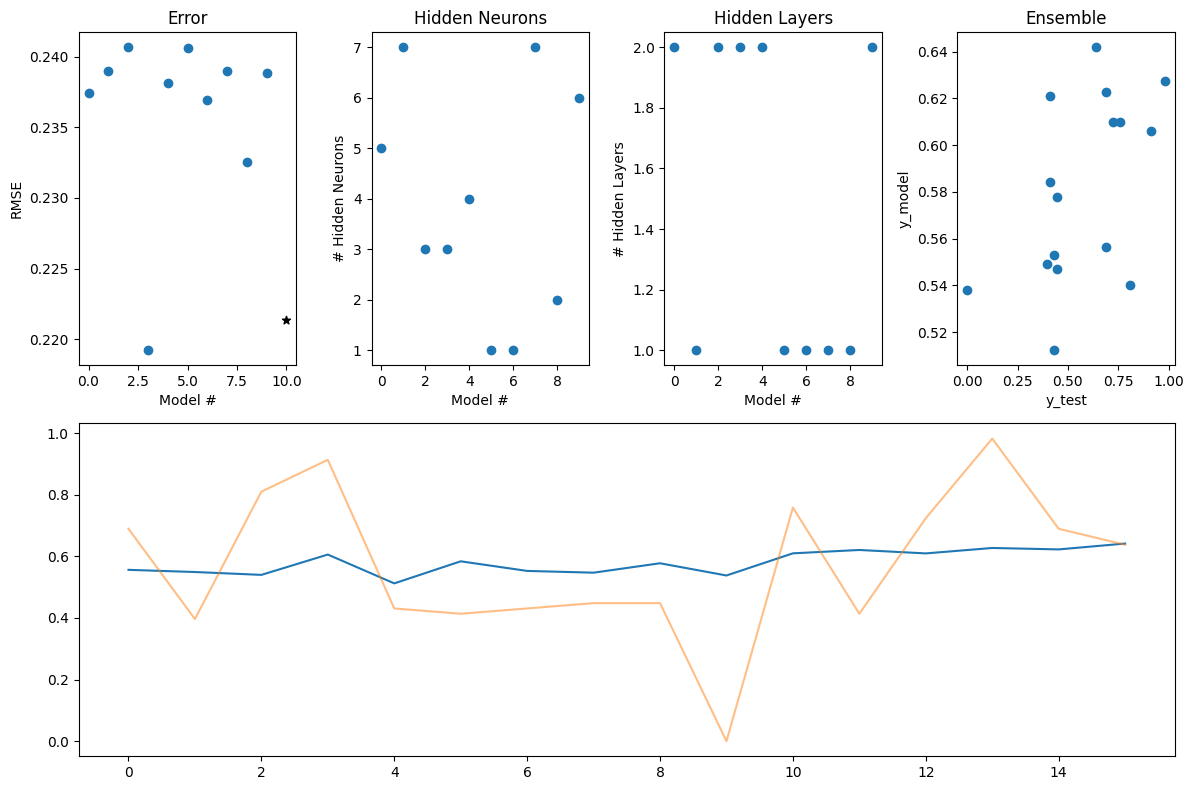

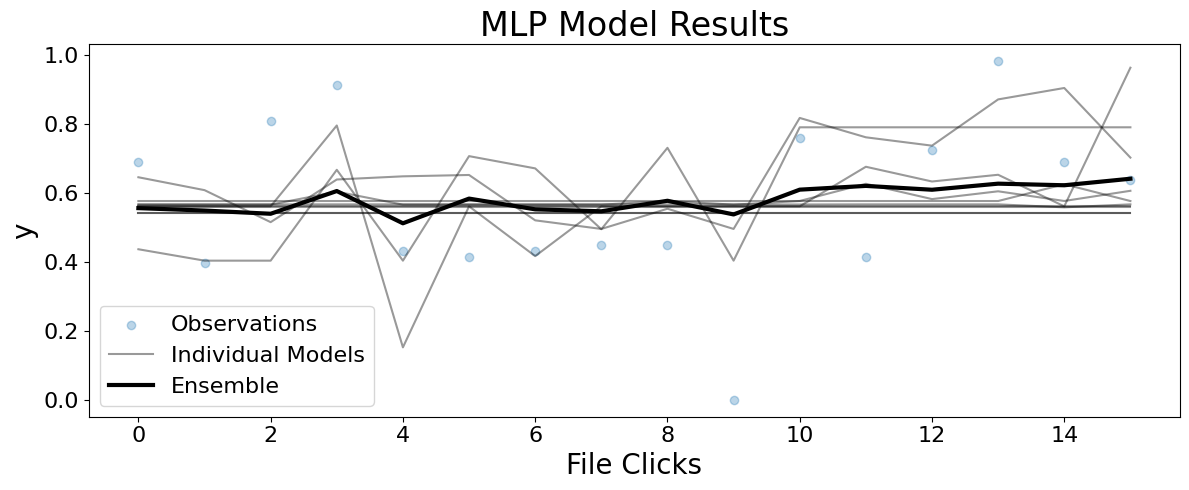

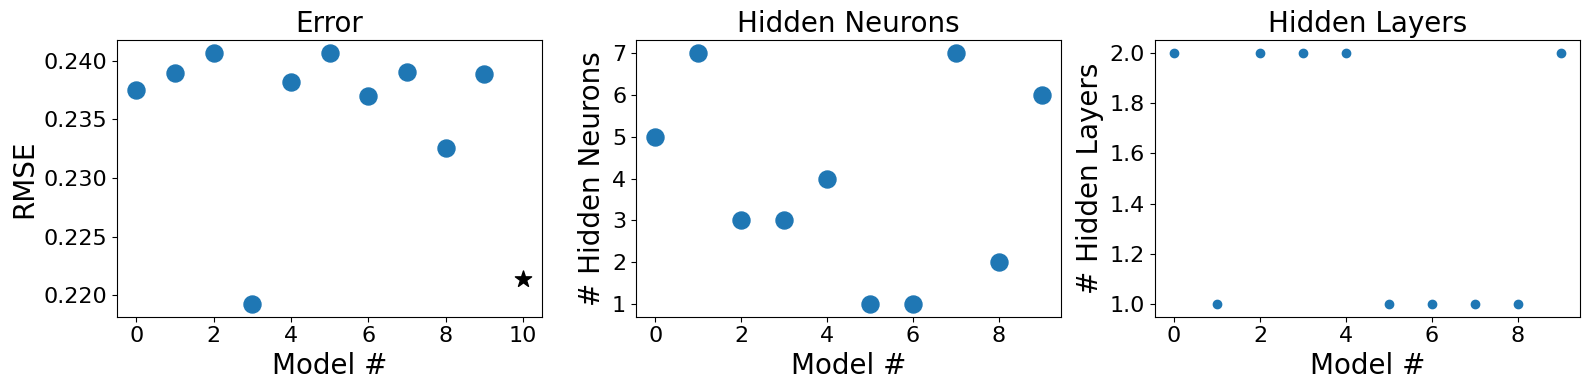

0.22139204788054476
RMSE on train data:  1.7386034741383352
RMSE on test data:  6.262109961029197
-2.2166965437664388e-05
RMSE on test data:  7.737770119340153
R^2: -0.5308459595959691


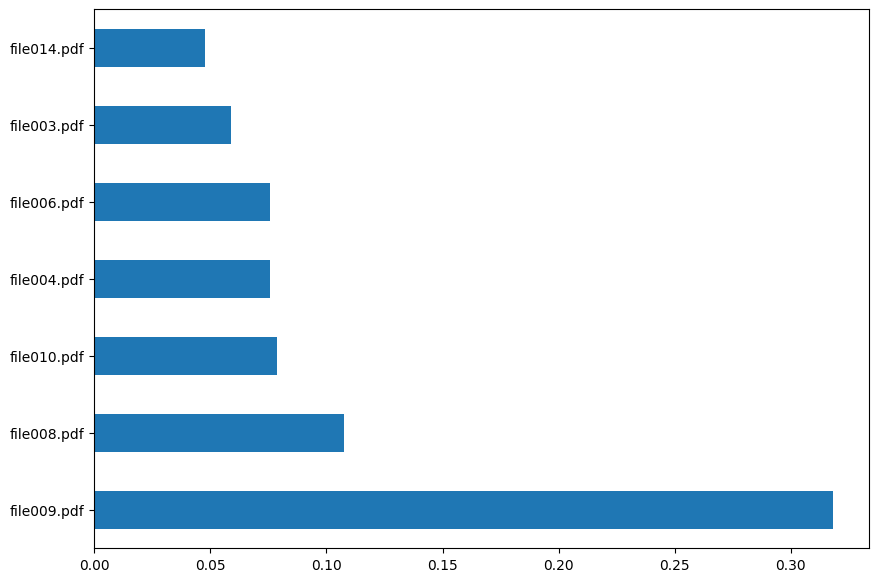

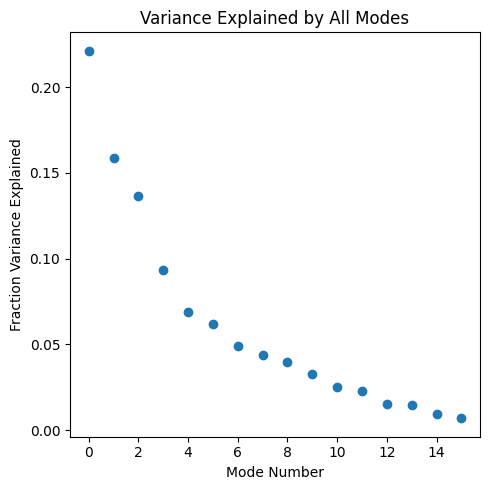

Model Number: 0
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 2 hidden layers, 5 hidden neurons
Model Number: 1
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

	 BEST: 1 hidden layers, 7 hidden neurons
Model Number: 2
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 4 hidden neurons
Model Number: 3
	 # Hidden Layers = 1
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8
	 BEST: 1 hidden layers, 3 hidden neurons
Model Number: 4
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 1 hidden neurons
Model Number: 5
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

	 BEST: 1 hidden layers, 7 hidden neurons
Model Number: 6
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 2 hidden layers, 8 hidden neurons
Model Number: 7
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-202

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 1 hidden neurons
Model Number: 8
	 # Hidden Layers = 1
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 2 hidden neurons
Model Number: 9
	 # Hidden Layers = 1
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 2 hidden layers, 2 hidden neurons


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


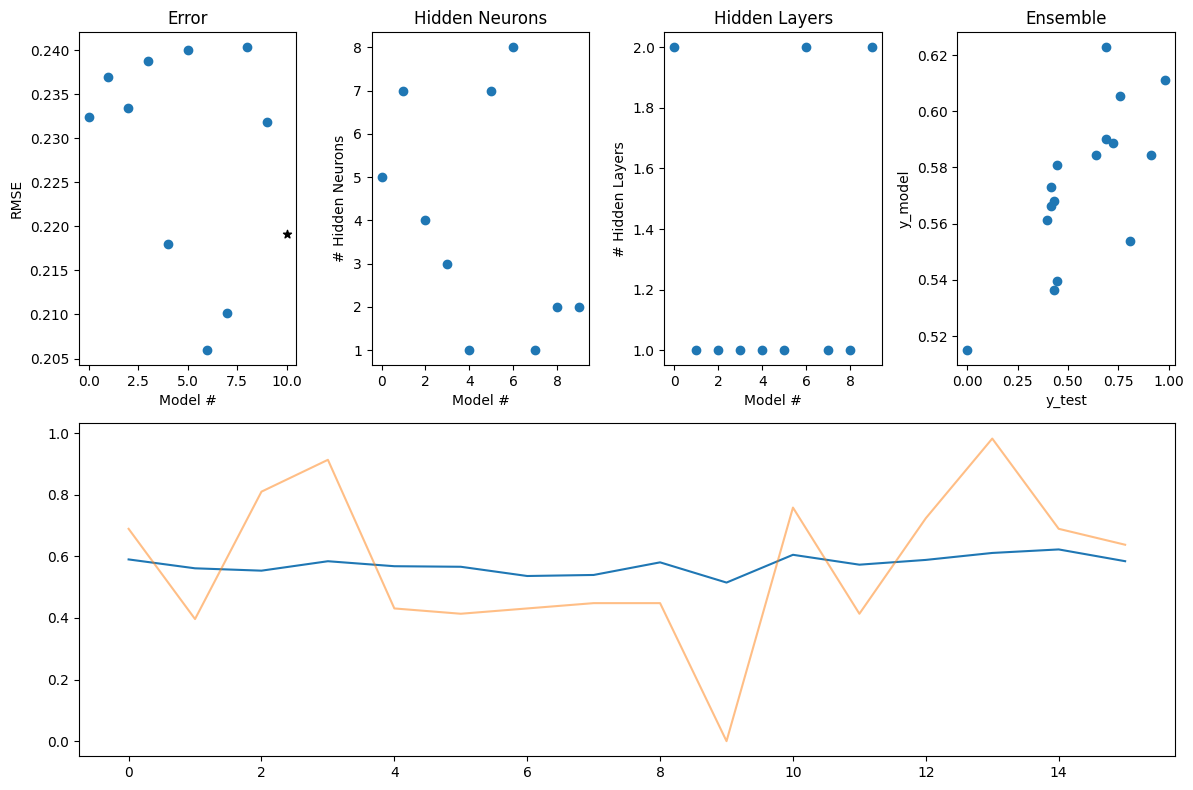

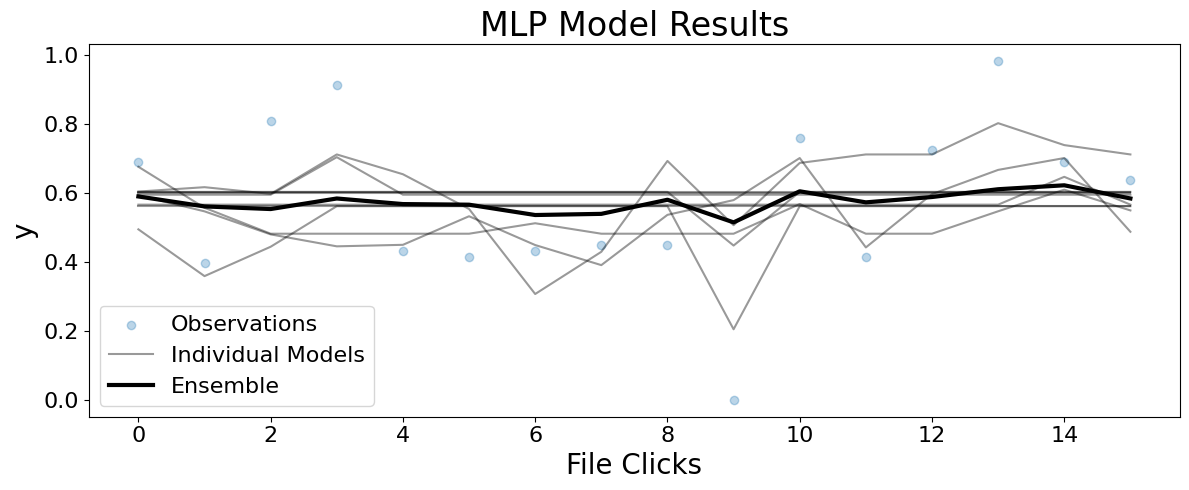

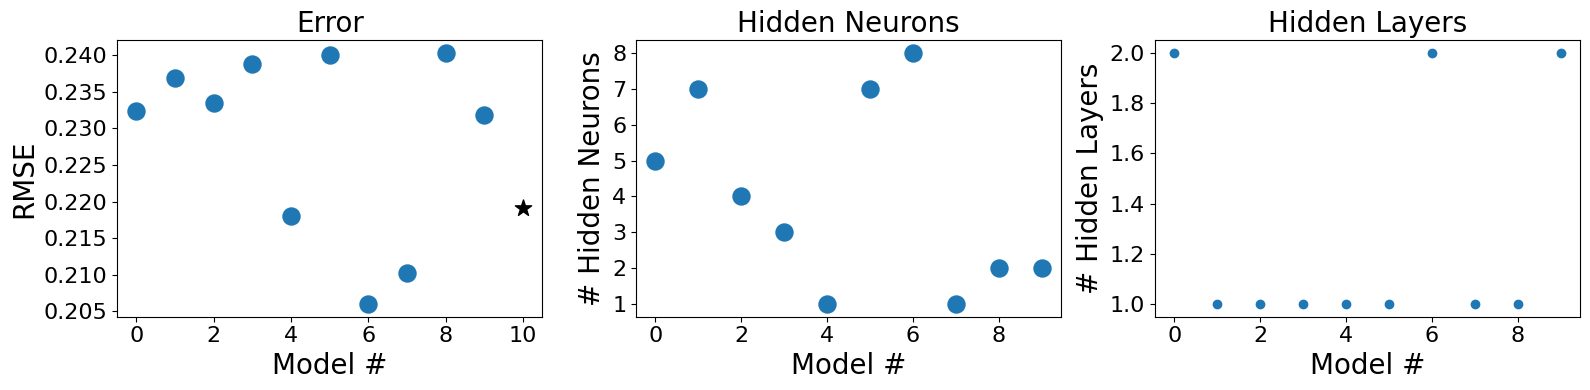

0.2191507068196288
RMSE on train data:  1.5261251029190182
RMSE on test data:  6.409783637429548
-0.04774353142247634
RMSE on test data:  3.840262039716433
R^2: 0.6229303613545925


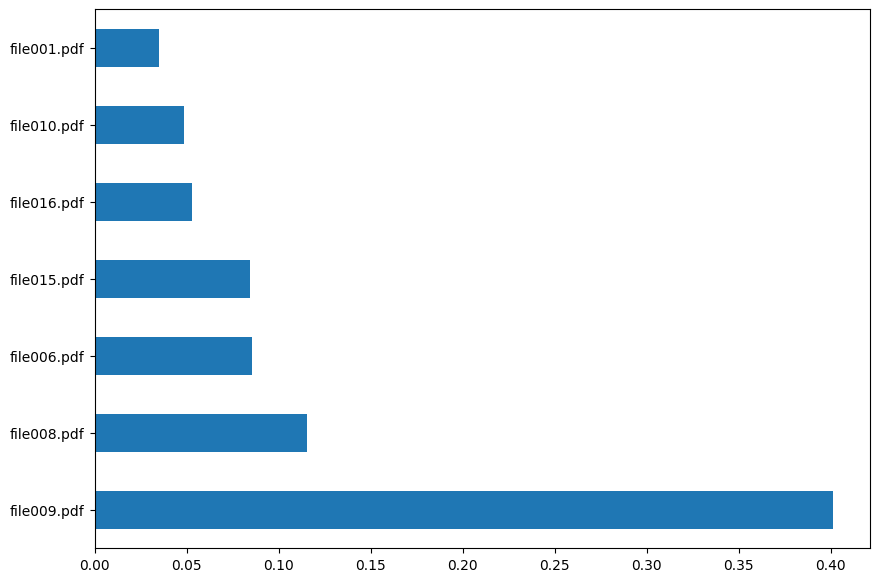

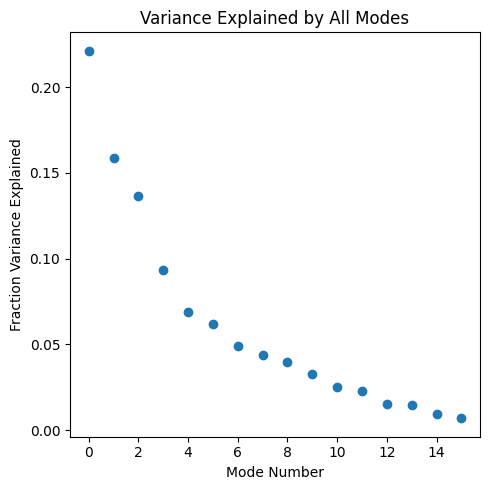

Model Number: 0
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 2 hidden layers, 4 hidden neurons
Model Number: 1
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4
		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 2 hidden layers, 7 hidden neurons
Model Number: 2
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

	 BEST: 2 hidden layers, 2 hidden neurons
Model Number: 3
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 3 hidden neurons
Model Number: 4
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 8
	 BEST: 1 hidden layers, 5 hidden neurons
Model Number: 5
	 # Hidden Layers = 1
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 8
	 BEST: 2 hidden layers, 3 hidden neurons
Model Number: 6
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 2 hidden neurons
Model Number: 7
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 6
		 # hidden neurons = 7


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 7 hidden neurons
Model Number: 8
	 # Hidden Layers = 1
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 5


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

	 BEST: 1 hidden layers, 5 hidden neurons
Model Number: 9
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

	 # Hidden Layers = 2
		 # hidden neurons = 1


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 8 hidden neurons


c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\Christie\VS Projects\hack-la-2023\.venv\lib\site-packag

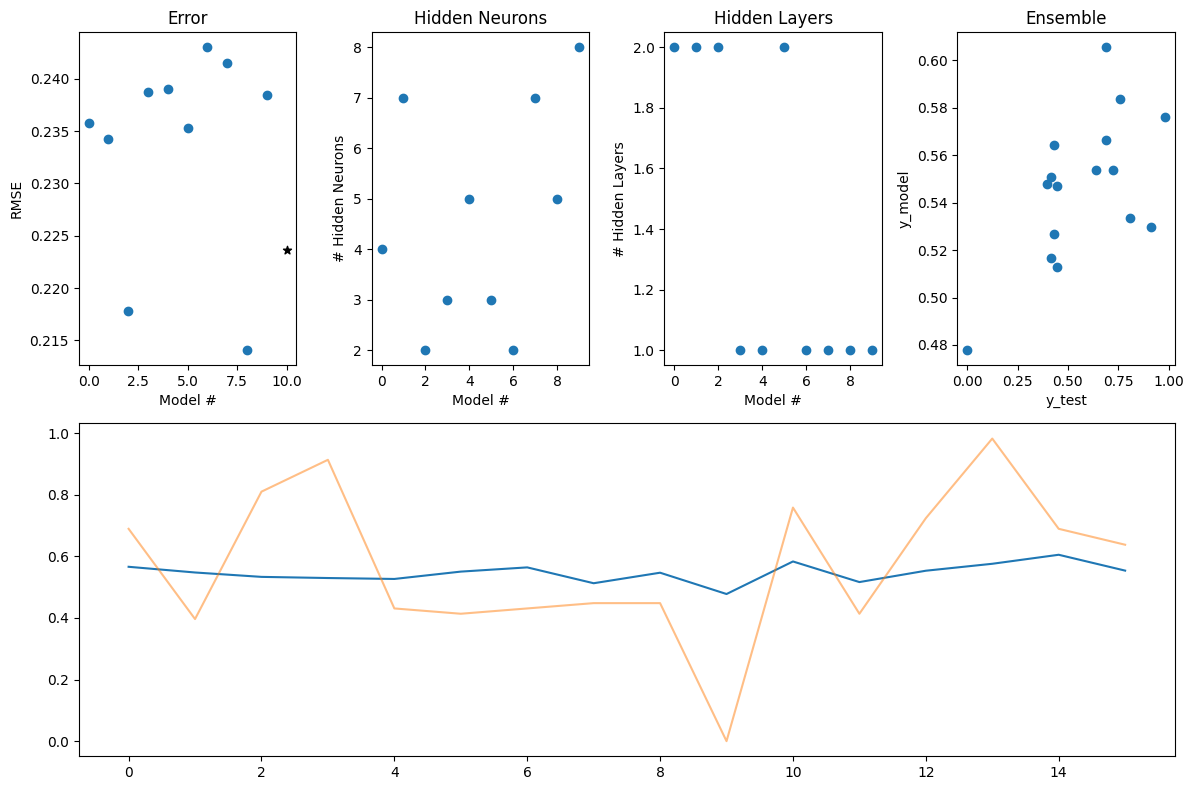

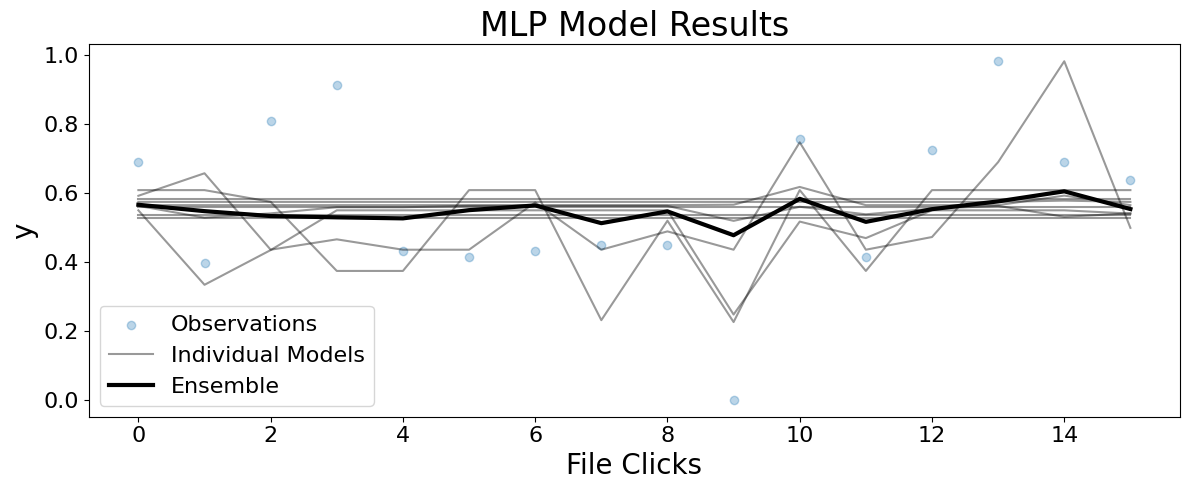

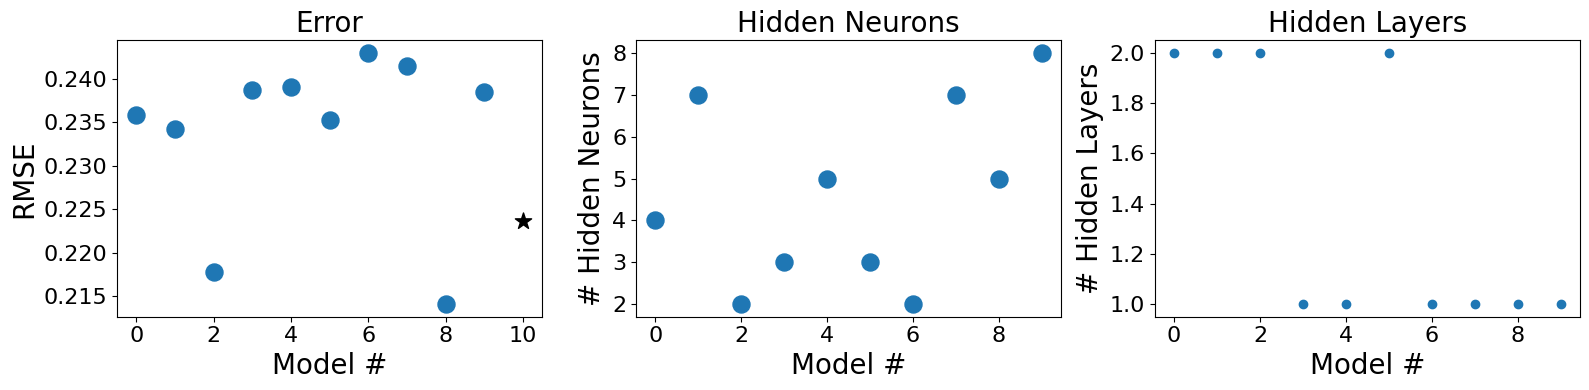

0.22360664169213437


In [62]:
df = pd.read_csv("CZHC\data\pdf.csv")
df =  df.fillna(0)
df.head()
df = df.drop([ 'actor_id'], axis=1)

files = ["CZHC\data\img.csv", 
         "CZHC\data\mod0.csv", 
         "CZHC\data\mod1.csv",
         "CZHC\data\mod2.csv",
         "CZHC\data\mod3.csv",
         "CZHC\data\mod4.csv",
         "CZHC\data\mod5.csv",
         "CZHC\data\mod6.csv",
         "CZHC\data\pdf.csv"]

fileName=["img", 
          "mod0", 
          "mod1",
          "mod2",
          "mod3",
          "mod4",
          "mod5",
          "mod6",
          "pdf",
          ]

for i in range(len(files)):
  df = pd.read_csv(files[i])
  df =  df.fillna(0)
  df.head()
  df = df.drop([ 'actor_id'], axis=1)

  randomForest(fileName[i])
  linearR(fileName[i])
  pcaMLPRegressor(fileName[i])
  

In [63]:
"""
# Get the indices that would sort the absolute loadings in descending order
component_number = 0  # Replace with the desired component number (0-based index)
sorted_indices = np.argsort(np.abs(eigvecs[component_number]))[::-1]

# Extract the variable names in order of influence
variable_names = x.columns
influential_variables = variable_names[sorted_indices]

influential_variables
"""


'\n# Get the indices that would sort the absolute loadings in descending order\ncomponent_number = 0  # Replace with the desired component number (0-based index)\nsorted_indices = np.argsort(np.abs(eigvecs[component_number]))[::-1]\n\n# Extract the variable names in order of influence\nvariable_names = x.columns\ninfluential_variables = variable_names[sorted_indices]\n\ninfluential_variables\n'

In [64]:
## OH GOD

#This chunk of code is relatively flexible and can be used to loop through a range of parameters
#We'll use this code several different times in the notebook
#Play around and see what kinds of models you can make

#First: MLP using 1 hidden layer with 10 neurons
#Second: MLP using 1 hidden layer with 1-10 neurons
#Third: something else!
"""
##### Play around with these parameters
num_models = 10 #number of models to build for the ensemble
min_nhn = 1 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')
max_nhn = 8 #maximum number of hidden neurons to loop through
max_hidden_layers = 2 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')
batch_size = 32
solver = 'adam' #use stochastic gradient descent as an optimization method (weight updating algorithm)
activation = 'relu'
learning_rate_init = 0.01
#####

max_iter = 1500 #max number of epochs to run
early_stopping = True #True = stop early if validation error begins to rise
validation_fraction = 0.1 #fraction of training data to use as validation

y_out_all_nhn = []
y_out_ensemble = []
RMSE_ensemble = [] #RMSE for each model in the ensemble
RMSE_ensemble_cumsum = [] #RMSE of the cumulative saltation for each model
nhn_best = []
nhl_best = []

for model_num in range(num_models): #for each model in the ensemble
    
    print('Model Number: ' + str(model_num))
    
    RMSE = []
    y_out_all_nhn = []
    nhn = []
    nhl = []
    
    for num_hidden_layers in range(1,max_hidden_layers+1):
    
        print('\t # Hidden Layers = ' + str(num_hidden_layers))
    
        for num_hidden_neurons in range(min_nhn,max_nhn+1): #for each number of hidden neurons

            print('\t\t # hidden neurons = ' + str(num_hidden_neurons))
            
            hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
            model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                                 verbose=False,
                                 max_iter=max_iter, 
                                 early_stopping = early_stopping,
                                 validation_fraction = validation_fraction,
                                 batch_size = batch_size,
                                 solver = solver,
                                 activation = activation,
                                 learning_rate_init = learning_rate_init)

            model.fit(x_train,y_train) #train the model

            y_out_this_nhn = model.predict(x_test) #model prediction for this number of hidden neurons (nhn)
            y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE

            RMSE.append(rmse(y_test,y_out_this_nhn)) #RMSE between cumulative curves
            
            nhn.append(num_hidden_neurons)
            nhl.append(num_hidden_layers)
        
    indBest = RMSE.index(np.min(RMSE)) #index of model with lowest RMSE
    RMSE_ensemble.append(np.min(RMSE))
    nhn_best.append(nhn[indBest])
    nhl_best.append(nhl[indBest])
    #nhn_best.append(indBest+1) #the number of hidden neurons that achieved best model performance of this model iteration
    y_out_ensemble.append(y_out_all_nhn[indBest])
    
    print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')
    
y_out_ensemble_mean = np.mean(y_out_ensemble,axis=0)
RMSE_ensemble_mean = rmse(y_out_ensemble_mean,y_test)
"""


"\n##### Play around with these parameters\nnum_models = 10 #number of models to build for the ensemble\nmin_nhn = 1 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')\nmax_nhn = 8 #maximum number of hidden neurons to loop through\nmax_hidden_layers = 2 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')\nbatch_size = 32\nsolver = 'adam' #use stochastic gradient descent as an optimization method (weight updating algorithm)\nactivation = 'relu'\nlearning_rate_init = 0.01\n#####\n\nmax_iter = 1500 #max number of epochs to run\nearly_stopping = True #True = stop early if validation error begins to rise\nvalidation_fraction = 0.1 #fraction of training data to use as validation\n\ny_out_all_nhn = []\ny_out_ensemble = []\nRMSE_ensemble = [] #RMSE for each model in the ensemble\nRMSE_ensemble_cumsum = [] #RMSE of the cumulative saltation for each model\nnhn_best = []\nnhl_best = []\n\nfor model_num in range(num_models): #for each mode

In [65]:

#visualize
"""
plt.figure(figsize=(12,8))

plt.subplot(241)
plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*')
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
plt.xlabel('Model #')
plt.ylabel('RMSE')
plt.title('Error')


plt.subplot(242)
plt.scatter(range(len(nhn_best)),nhn_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Neurons')
plt.title('Hidden Neurons')

plt.subplot(243)
plt.scatter(range(len(nhl_best)),nhl_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Layers')
plt.title('Hidden Layers')

plt.subplot(244)
plt.scatter(y_test,y_out_ensemble_mean)
#plt.plot((np.min(y_test),np.max(y_test)),'k--')
plt.xlabel('y_test')
plt.ylabel('y_model')
plt.title('Ensemble')

plt.subplot(212)
plt.plot(y_out_ensemble_mean)
plt.plot(np.array(y_test),alpha = 0.5)

plt.tight_layout()

#visualize individual model runs


plt.figure(figsize = (12,5))

plt.scatter(range(len(y_test)),y_test,label='Observations',zorder = 0,alpha = 0.3)
plt.plot(range(len(y_test)),np.transpose(y_out_ensemble[0]),
         color = 'k',alpha = 0.4,label='Individual Models',zorder=1) #plot first ensemble member with a label
plt.plot(range(len(y_test)),np.transpose(y_out_ensemble[1:]),
         color = 'k',alpha = 0.4,zorder=1) #plot remaining ensemble members without labels for a nicer legend
plt.plot(range(len(y_test)),y_out_ensemble_mean,color = 'k',label = 'Ensemble',zorder=2, linewidth = 3)
plt.xlabel('Time', fontsize = 20)
plt.ylabel('y', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('MLP Model Results', fontsize = 24)
plt.legend(fontsize = 16, loc = 'best')

plt.tight_layout()

plt.show()

#visualize performance metrics/etc


plt.figure(figsize=(16,4))

plt.subplot(131)
plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*', s = 150)
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble, s = 150)
plt.xlabel('Model #', fontsize = 20)
plt.ylabel('RMSE', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
#plt.ylim((np.min(RMSE_ensemble) - 0.005, np.max(RMSE_ensemble)+0.005))
plt.title('Error', fontsize = 20)

plt.subplot(132)
plt.scatter(range(len(nhn_best)),nhn_best, s = 150)
plt.xlabel('Model #', fontsize = 20)
plt.ylabel('# Hidden Neurons', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Hidden Neurons', fontsize = 20)

plt.subplot(133)
plt.scatter(range(len(nhl_best)),nhl_best)
plt.xlabel('Model #', fontsize = 20)
plt.ylabel('# Hidden Layers', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Hidden Layers', fontsize = 20)

plt.tight_layout()

plt.show()

print(RMSE_ensemble_mean)
"""

"\nplt.figure(figsize=(12,8))\n\nplt.subplot(241)\nplt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*')\nplt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)\nplt.xlabel('Model #')\nplt.ylabel('RMSE')\nplt.title('Error')\n\n\nplt.subplot(242)\nplt.scatter(range(len(nhn_best)),nhn_best)\nplt.xlabel('Model #')\nplt.ylabel('# Hidden Neurons')\nplt.title('Hidden Neurons')\n\nplt.subplot(243)\nplt.scatter(range(len(nhl_best)),nhl_best)\nplt.xlabel('Model #')\nplt.ylabel('# Hidden Layers')\nplt.title('Hidden Layers')\n\nplt.subplot(244)\nplt.scatter(y_test,y_out_ensemble_mean)\n#plt.plot((np.min(y_test),np.max(y_test)),'k--')\nplt.xlabel('y_test')\nplt.ylabel('y_model')\nplt.title('Ensemble')\n\nplt.subplot(212)\nplt.plot(y_out_ensemble_mean)\nplt.plot(np.array(y_test),alpha = 0.5)\n\nplt.tight_layout()\n\n#visualize individual model runs\n\n\nplt.figure(figsize = (12,5))\n\nplt.scatter(range(len(y_test)),y_test,label='Observations',zorder = 0,alpha = 0.3)\nplt.plot(range(len(